In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from BaseModel import MnistModel
from utils import load_mnist
import numpy as np
import matplotlib.pyplot as plt
import tqdm

### load MNIST data

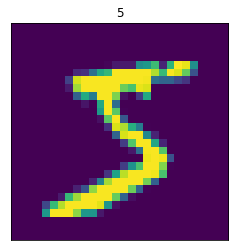

In [2]:
MNIST_path = '/home/nvidia/LINMUX/Datasets/mnist/mnist.npz'
x_train, y_train, x_test, y_test, _, _ = load_mnist(path=MNIST_path)

plt.xticks([])
plt.yticks([])
plt.title(y_train[0])
plt.imshow(np.squeeze(x_train[0]))

### train model function and test model function

In [3]:
def train(model, x, y, batch_size):
    data = np.copy(x)
    data = data.transpose((0, 3, 1, 2))
    labels = np.copy(y)
    seq = np.arange(0, data.shape[0], batch_size)
    seq = np.append(seq, data.shape[0])
    total_loss = 0
    total_correct = 0
    for i in range(seq.shape[0]-1):
        optimizer.zero_grad()
        inputs = torch.Tensor(data[seq[i]: seq[i+1]]).cuda()
        targets = torch.Tensor(labels[seq[i]: seq[i+1]]).cuda().long()
        outputs = model(inputs)
        _, preds = outputs.max(1)
        loss = criterizion(outputs, targets)
        total_loss += loss.item()
        total_correct += preds.eq(targets).sum().item()

        loss.backward()
        optimizer.step()
    acc = total_correct/data.shape[0]
    print(' Train Loss: {:.4f} | Train Acc: {:.4f}'.format(total_loss, acc))


def test(model, x, y, batch_size):
    data = np.copy(x)
    data = data.transpose((0, 3, 1, 2))
    labels = np.copy(y)
    seq = np.arange(0, data.shape[0], batch_size)
    seq = np.append(seq, data.shape[0])
    with torch.no_grad():
        total_correct = 0
        for i in range(seq.shape[0]-1):
            inputs = torch.Tensor(data[seq[i]: seq[i+1]]).cuda()
            targets = torch.Tensor(labels[seq[i]: seq[i+1]]).cuda().long()
            outputs = model(inputs)
            _, preds = outputs.max(1)
            total_correct += preds.eq(targets).sum().item()
    acc = total_correct/data.shape[0]
    print(' Test Acc:{:.4f}({}/{})'.format(acc, total_correct, data.shape[0]))

### unTrained model

In [4]:
unTrainModel = MnistModel().cuda()
test(unTrainModel, x=x_test, y=y_test, batch_size=128)

 Test Acc:0.1253(1253/10000)


### Trained model

In [26]:
TrainModel = MnistModel().cuda()
optimizer = optim.Adam(TrainModel.parameters(), lr=1e-3)
criterizion = nn.CrossEntropyLoss()
epochs = 10
for epoch in range(epochs):
    print('Epoch:{}'.format(epoch+1))
    train(model=TrainModel, x=x_train, y=y_train, batch_size=128)
    test(model=TrainModel, x=x_test, y=y_test, batch_size=128)

Epoch:1
 Train Loss: 241.5468 | Train Acc: 0.8512
 Test Acc:0.9513(9513/10000)
Epoch:2
 Train Loss: 67.1283 | Train Acc: 0.9566
 Test Acc:0.9710(9710/10000)
Epoch:3
 Train Loss: 45.7111 | Train Acc: 0.9701
 Test Acc:0.9757(9757/10000)
Epoch:4
 Train Loss: 36.3148 | Train Acc: 0.9757
 Test Acc:0.9790(9790/10000)
Epoch:5
 Train Loss: 30.2145 | Train Acc: 0.9798
 Test Acc:0.9800(9800/10000)
Epoch:6
 Train Loss: 26.0048 | Train Acc: 0.9825
 Test Acc:0.9799(9799/10000)
Epoch:7
 Train Loss: 22.9358 | Train Acc: 0.9849
 Test Acc:0.9815(9815/10000)
Epoch:8
 Train Loss: 20.6106 | Train Acc: 0.9865
 Test Acc:0.9832(9832/10000)
Epoch:9
 Train Loss: 18.7669 | Train Acc: 0.9878
 Test Acc:0.9834(9834/10000)
Epoch:10
 Train Loss: 17.1415 | Train Acc: 0.9887
 Test Acc:0.9837(9837/10000)


### drawing function

In [27]:
def draw_subfunction(model, images, plt_name, ax, batch_size=128, num_classes=10):
    seq = np.arange(0, images.shape[0], batch_size)
    seq = np.append(seq, images.shape[0])
    all_outputs = []
    with torch.no_grad():
        for i in range(seq.shape[0] - 1):
            inputs = images[seq[i]: seq[i + 1]]
            inputs = torch.Tensor(inputs).cuda()
            outputs = model(inputs)
            _, preds = outputs.max(1)
            preds = preds.cpu().detach().numpy()
            all_outputs.append(preds)
    all_outputs = np.concatenate(all_outputs, axis=0)
    counts = np.bincount(all_outputs, minlength=num_classes)
    color_list = [item['color'] for item in list(plt.rcParams['axes.prop_cycle'])]
    if num_classes == 10:
        ax.bar(x=np.arange(10), height=counts , color=color_list)
    else:
        ax.bar(x=np.arange(10), height=np.sort(counts)[-10:] , color=color_list)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plt_name)

***
Question demo: the predictions of model is not random
***

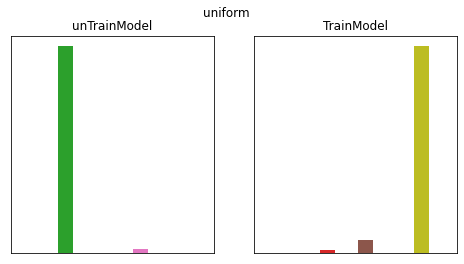

In [7]:
uniform_random_images = np.random.uniform(low=0, high=1, size=(10000, 1, 28, 28))
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
draw_subfunction(unTrainModel, uniform_random_images, plt_name='unTrainModel', ax=ax1)
draw_subfunction(TrainModel, uniform_random_images, plt_name='TrainModel', ax=ax2)
fig.suptitle('uniform')
plt.show()

*Question 1*:
**Is the effects of random images relative to distribution?**

- Step1: change the distribution of random images:
          distributional functions: [gaussian, beta, uniform, weibull, dirichlet]
- Step2: check the bar plot

*Answer 1*:
- Yes! the distribution of data is effective to model classify result 

### different noise

In [8]:
# gaussian
gaussian_random_images = np.random.randn(10000, 1, 28, 28)/6+0.5
gaussian_random_images = np.clip(0, 1, gaussian_random_images)

# beta
beta_random_images = np.random.beta(a=1, b=1, size=(10000, 1, 28, 28))
beta_random_images = np.clip(0, 1, beta_random_images)

# uniform
uniform_random_images = np.random.uniform(low=1, high=1, size=(10000, 1, 28, 28))
uniform_random_images = np.clip(0, 1, uniform_random_images)

# weibull
weibull_random_images = np.random.weibull(a=10, size=(10000, 1, 28, 28))
weibull_random_images = np.clip(0, 1, weibull_random_images)

# dirichlet
dirichlet_random_images = np.random.dirichlet(([1]), size=(10000, 1, 28, 28)).reshape((10000, 1, 28, 28))
dirichlet_random_images = np.clip(0, 1, dirichlet_random_images)

# Mnist dataset
mnist_data = x_train[:10000].transpose(0, 3, 1, 2)

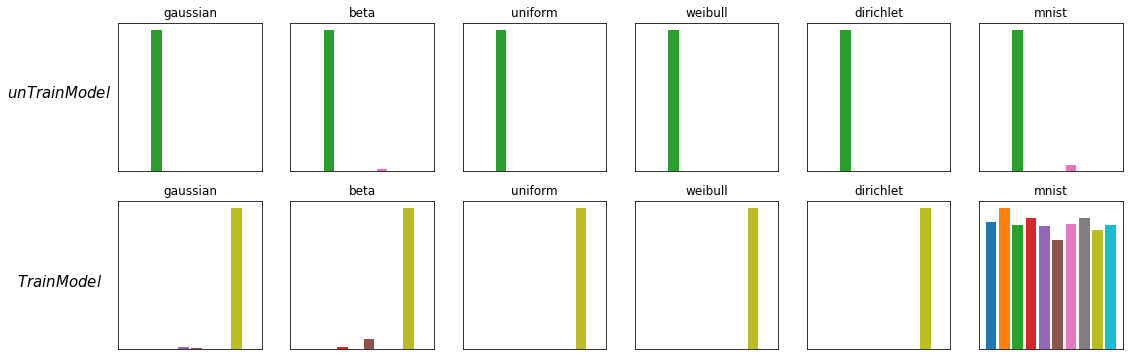

In [9]:
random_images = [gaussian_random_images, beta_random_images, uniform_random_images,
                 weibull_random_images, dirichlet_random_images, mnist_data]
noise_name = ['gaussian', 'beta', 'uniform', 'weibull', 'dirichlet', 'mnist']
fig = plt.figure(figsize=(18, 6))
for i in range(6):
    ax1 = fig.add_subplot(2, 6, i+1)
    ax2 = fig.add_subplot(2, 6, i+7)
    draw_subfunction(model=unTrainModel, images=random_images[i], plt_name=noise_name[i], ax=ax1)
    draw_subfunction(model=TrainModel, images=random_images[i], plt_name=noise_name[i], ax=ax2)
plt.text(-70, 2000, s='$unTrainModel$', ha='center', fontsize=15, family='monospace', weight='bold')
plt.text(-70, 500, s='$TrainModel$', ha='center', fontsize=15, family='monospace', weight='bold')
plt.show()


*Question 2*: **Does the model could work better if we add noises to images through data augment?**

- Step1: add different noise to image and retrain the model
- step2: evaluate the model 

*Answer 2*: Yes. **Not only working better but also being closed the distribution of noises.**


### Gaussian

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch:1
 Train Loss: 1079.4081 | Train Acc: 0.1116
 Test Acc:0.1028
Epoch:2
 Train Loss: 1079.3326 | Train Acc: 0.1122
 Test Acc:0.1026
Epoch:3
 Train Loss: 1079.3110 | Train Acc: 0.1123
 Test Acc:0.1027
Epoch:4
 Train Loss: 1079.3109 | Train Acc: 0.1118
 Test Acc:0.1135
Epoch:5
 Train Loss: 1079.3079 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:6
 Train Loss: 1079.3076 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:7
 Train Loss: 1079.3037 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:8
 Train Loss: 1079.3003 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:9
 Train Loss: 1079.2989 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:10
 Train Loss: 1079.2963 | Train Acc: 0.1124
 Test Acc:0.1135


  9%|▉         | 1/11 [00:36<06:08, 36.87s/it]

Epoch:1
 Train Loss: 859.3936 | Train Acc: 0.3397
 Test Acc:0.7667
Epoch:2
 Train Loss: 629.7083 | Train Acc: 0.5357
 Test Acc:0.8227
Epoch:3
 Train Loss: 602.2274 | Train Acc: 0.5591
 Test Acc:0.8416
Epoch:4
 Train Loss: 583.7514 | Train Acc: 0.5711
 Test Acc:0.8668
Epoch:5
 Train Loss: 570.1616 | Train Acc: 0.5808
 Test Acc:0.8749
Epoch:6
 Train Loss: 560.6257 | Train Acc: 0.5895
 Test Acc:0.8787
Epoch:7
 Train Loss: 549.4104 | Train Acc: 0.5976
 Test Acc:0.8970
Epoch:8
 Train Loss: 545.8096 | Train Acc: 0.6012
 Test Acc:0.8895
Epoch:9
 Train Loss: 534.8750 | Train Acc: 0.6098
 Test Acc:0.9029
Epoch:10
 Train Loss: 532.4505 | Train Acc: 0.6110
 Test Acc:0.9034


 18%|█▊        | 2/11 [01:07<05:00, 33.35s/it]

Epoch:1
 Train Loss: 506.6101 | Train Acc: 0.6508
 Test Acc:0.8952
Epoch:2
 Train Loss: 256.8583 | Train Acc: 0.8195
 Test Acc:0.9170
Epoch:3
 Train Loss: 214.2974 | Train Acc: 0.8515
 Test Acc:0.9401
Epoch:4
 Train Loss: 189.6655 | Train Acc: 0.8677
 Test Acc:0.9492
Epoch:5
 Train Loss: 173.8073 | Train Acc: 0.8782
 Test Acc:0.9551
Epoch:6
 Train Loss: 158.5730 | Train Acc: 0.8888
 Test Acc:0.9595
Epoch:7
 Train Loss: 149.7598 | Train Acc: 0.8946
 Test Acc:0.9611
Epoch:8
 Train Loss: 139.7417 | Train Acc: 0.9026
 Test Acc:0.9635
Epoch:9
 Train Loss: 133.5157 | Train Acc: 0.9061
 Test Acc:0.9661
Epoch:10
 Train Loss: 127.2805 | Train Acc: 0.9103
 Test Acc:0.9664


 27%|██▋       | 3/11 [01:37<04:13, 31.71s/it]

Epoch:1
 Train Loss: 397.7989 | Train Acc: 0.7433
 Test Acc:0.8948
Epoch:2
 Train Loss: 174.3398 | Train Acc: 0.8843
 Test Acc:0.9353
Epoch:3
 Train Loss: 124.9855 | Train Acc: 0.9167
 Test Acc:0.9550
Epoch:4
 Train Loss: 99.7305 | Train Acc: 0.9326
 Test Acc:0.9642
Epoch:5
 Train Loss: 85.3540 | Train Acc: 0.9420
 Test Acc:0.9688
Epoch:6
 Train Loss: 75.3487 | Train Acc: 0.9491
 Test Acc:0.9721
Epoch:7
 Train Loss: 69.3727 | Train Acc: 0.9529
 Test Acc:0.9763
Epoch:8
 Train Loss: 64.1928 | Train Acc: 0.9570
 Test Acc:0.9797
Epoch:9
 Train Loss: 59.3194 | Train Acc: 0.9596
 Test Acc:0.9804
Epoch:10
 Train Loss: 58.5411 | Train Acc: 0.9600
 Test Acc:0.9813


 36%|███▋      | 4/11 [02:08<03:40, 31.53s/it]

Epoch:1
 Train Loss: 323.6809 | Train Acc: 0.7947
 Test Acc:0.9199
Epoch:2
 Train Loss: 118.4318 | Train Acc: 0.9227
 Test Acc:0.9465
Epoch:3
 Train Loss: 84.6658 | Train Acc: 0.9445
 Test Acc:0.9551
Epoch:4
 Train Loss: 68.5527 | Train Acc: 0.9543
 Test Acc:0.9648
Epoch:5
 Train Loss: 59.9033 | Train Acc: 0.9601
 Test Acc:0.9683
Epoch:6
 Train Loss: 52.5377 | Train Acc: 0.9644
 Test Acc:0.9739
Epoch:7
 Train Loss: 47.5755 | Train Acc: 0.9681
 Test Acc:0.9751
Epoch:8
 Train Loss: 44.5677 | Train Acc: 0.9695
 Test Acc:0.9757
Epoch:9
 Train Loss: 40.9185 | Train Acc: 0.9721
 Test Acc:0.9775
Epoch:10
 Train Loss: 38.3235 | Train Acc: 0.9741
 Test Acc:0.9795


 45%|████▌     | 5/11 [02:39<03:07, 31.29s/it]

Epoch:1
 Train Loss: 330.7398 | Train Acc: 0.7876
 Test Acc:0.9088
Epoch:2
 Train Loss: 106.1338 | Train Acc: 0.9313
 Test Acc:0.9531
Epoch:3
 Train Loss: 69.2922 | Train Acc: 0.9545
 Test Acc:0.9641
Epoch:4
 Train Loss: 55.1542 | Train Acc: 0.9638
 Test Acc:0.9706
Epoch:5
 Train Loss: 46.8356 | Train Acc: 0.9695
 Test Acc:0.9753
Epoch:6
 Train Loss: 41.0690 | Train Acc: 0.9732
 Test Acc:0.9763
Epoch:7
 Train Loss: 37.3852 | Train Acc: 0.9749
 Test Acc:0.9778
Epoch:8
 Train Loss: 34.1313 | Train Acc: 0.9769
 Test Acc:0.9745
Epoch:9
 Train Loss: 31.5926 | Train Acc: 0.9787
 Test Acc:0.9762
Epoch:10
 Train Loss: 30.0359 | Train Acc: 0.9791
 Test Acc:0.9791


 55%|█████▍    | 6/11 [03:08<02:33, 30.63s/it]

Epoch:1
 Train Loss: 290.5377 | Train Acc: 0.8174
 Test Acc:0.9220
Epoch:2
 Train Loss: 95.3314 | Train Acc: 0.9397
 Test Acc:0.9529
Epoch:3
 Train Loss: 64.9752 | Train Acc: 0.9585
 Test Acc:0.9622
Epoch:4
 Train Loss: 51.5663 | Train Acc: 0.9665
 Test Acc:0.9659
Epoch:5
 Train Loss: 42.9977 | Train Acc: 0.9725
 Test Acc:0.9668
Epoch:6
 Train Loss: 37.3428 | Train Acc: 0.9762
 Test Acc:0.9725
Epoch:7
 Train Loss: 33.5164 | Train Acc: 0.9782
 Test Acc:0.9735
Epoch:8
 Train Loss: 30.1312 | Train Acc: 0.9804
 Test Acc:0.9761
Epoch:9
 Train Loss: 27.4207 | Train Acc: 0.9825
 Test Acc:0.9780
Epoch:10
 Train Loss: 25.6248 | Train Acc: 0.9833
 Test Acc:0.9767


 64%|██████▎   | 7/11 [03:39<02:02, 30.68s/it]

Epoch:1
 Train Loss: 257.8350 | Train Acc: 0.8426
 Test Acc:0.9374
Epoch:2
 Train Loss: 72.7319 | Train Acc: 0.9530
 Test Acc:0.9609
Epoch:3
 Train Loss: 50.4511 | Train Acc: 0.9669
 Test Acc:0.9665
Epoch:4
 Train Loss: 40.5966 | Train Acc: 0.9733
 Test Acc:0.9699
Epoch:5
 Train Loss: 34.5365 | Train Acc: 0.9774
 Test Acc:0.9753
Epoch:6
 Train Loss: 30.1961 | Train Acc: 0.9800
 Test Acc:0.9780
Epoch:7
 Train Loss: 26.7631 | Train Acc: 0.9823
 Test Acc:0.9797
Epoch:8
 Train Loss: 24.2667 | Train Acc: 0.9841
 Test Acc:0.9820
Epoch:9
 Train Loss: 21.8954 | Train Acc: 0.9855
 Test Acc:0.9841
Epoch:10
 Train Loss: 19.6079 | Train Acc: 0.9875
 Test Acc:0.9822


 73%|███████▎  | 8/11 [04:09<01:31, 30.52s/it]

Epoch:1
 Train Loss: 246.9247 | Train Acc: 0.8502
 Test Acc:0.9303
Epoch:2
 Train Loss: 79.0795 | Train Acc: 0.9500
 Test Acc:0.9629
Epoch:3
 Train Loss: 53.6152 | Train Acc: 0.9661
 Test Acc:0.9740
Epoch:4
 Train Loss: 41.4503 | Train Acc: 0.9734
 Test Acc:0.9773
Epoch:5
 Train Loss: 34.7494 | Train Acc: 0.9779
 Test Acc:0.9795
Epoch:6
 Train Loss: 30.1350 | Train Acc: 0.9804
 Test Acc:0.9804
Epoch:7
 Train Loss: 26.7496 | Train Acc: 0.9825
 Test Acc:0.9822
Epoch:8
 Train Loss: 23.9312 | Train Acc: 0.9848
 Test Acc:0.9825
Epoch:9
 Train Loss: 21.3321 | Train Acc: 0.9865
 Test Acc:0.9830
Epoch:10
 Train Loss: 19.6830 | Train Acc: 0.9871
 Test Acc:0.9835


 82%|████████▏ | 9/11 [04:43<01:02, 31.50s/it]

Epoch:1
 Train Loss: 233.4955 | Train Acc: 0.8558
 Test Acc:0.9404
Epoch:2
 Train Loss: 77.9393 | Train Acc: 0.9491
 Test Acc:0.9622
Epoch:3
 Train Loss: 53.7869 | Train Acc: 0.9644
 Test Acc:0.9710
Epoch:4
 Train Loss: 41.9139 | Train Acc: 0.9720
 Test Acc:0.9751
Epoch:5
 Train Loss: 34.5718 | Train Acc: 0.9774
 Test Acc:0.9792
Epoch:6
 Train Loss: 29.5576 | Train Acc: 0.9806
 Test Acc:0.9820
Epoch:7
 Train Loss: 25.8051 | Train Acc: 0.9833
 Test Acc:0.9828
Epoch:8
 Train Loss: 22.9520 | Train Acc: 0.9850
 Test Acc:0.9833
Epoch:9
 Train Loss: 20.5974 | Train Acc: 0.9867
 Test Acc:0.9840
Epoch:10
 Train Loss: 18.5249 | Train Acc: 0.9879
 Test Acc:0.9824


 91%|█████████ | 10/11 [05:13<00:31, 31.13s/it]

Epoch:1
 Train Loss: 241.7654 | Train Acc: 0.8515
 Test Acc:0.9491
Epoch:2
 Train Loss: 65.5506 | Train Acc: 0.9578
 Test Acc:0.9691
Epoch:3
 Train Loss: 44.6289 | Train Acc: 0.9709
 Test Acc:0.9762
Epoch:4
 Train Loss: 35.6390 | Train Acc: 0.9769
 Test Acc:0.9807
Epoch:5
 Train Loss: 30.1118 | Train Acc: 0.9808
 Test Acc:0.9818
Epoch:6
 Train Loss: 26.2705 | Train Acc: 0.9833
 Test Acc:0.9828
Epoch:7
 Train Loss: 23.2486 | Train Acc: 0.9850
 Test Acc:0.9829
Epoch:8
 Train Loss: 20.8124 | Train Acc: 0.9866
 Test Acc:0.9829
Epoch:9
 Train Loss: 18.8910 | Train Acc: 0.9880
 Test Acc:0.9836
Epoch:10
 Train Loss: 17.0392 | Train Acc: 0.9893
 Test Acc:0.9840


100%|██████████| 11/11 [05:44<00:00, 31.31s/it]


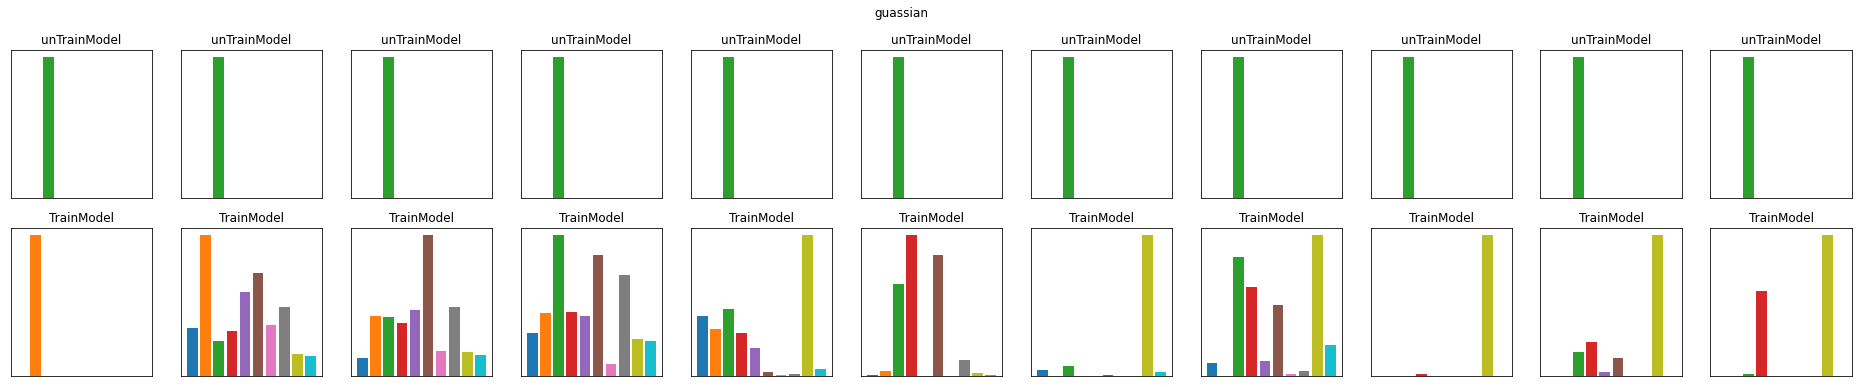

In [10]:
fig = plt.figure(figsize=(33, 6))
for i in tqdm.trange(11):
    TrainModel = MnistModel().cuda()
    optimizer = optim.Adam(TrainModel.parameters(), lr=1e-3)
    criterizion = nn.CrossEntropyLoss()
    epochs = 10
    for epoch in range(epochs):
        print('Epoch:{}'.format(epoch+1))
        gaussian_random_images = np.random.randn(*x_train.shape) / 6 + 0.5
        train_data = x_train*i*0.1+gaussian_random_images*(1-i*0.1) # from 0 to 1, step is 0.1
        train_data = np.clip(0, 1, train_data)
        train(model=TrainModel, x=train_data, y=y_train, batch_size=128)
        test(model=TrainModel, x=x_test, y=y_test, batch_size=128)

    ax1 = fig.add_subplot(2, 11, i+1)
    ax2 = fig.add_subplot(2, 11, i+12)
    gaussian_random_images = np.random.randn(10000, 1, 28, 28)/6+0.5
    gaussian_random_images = np.clip(0, 1, gaussian_random_images)
    draw_subfunction(unTrainModel, images=gaussian_random_images, plt_name='unTrainModel', ax=ax1)
    draw_subfunction(TrainModel, images=gaussian_random_images, plt_name='TrainModel', ax=ax2)
fig.suptitle('guassian')
plt.show()

### beta

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch:1
 Train Loss: 1079.4479 | Train Acc: 0.1120
 Test Acc:0.1759
Epoch:2
 Train Loss: 1079.3316 | Train Acc: 0.1120
 Test Acc:0.1136
Epoch:3
 Train Loss: 1079.3321 | Train Acc: 0.1123
 Test Acc:0.1135
Epoch:4
 Train Loss: 1079.3121 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:5
 Train Loss: 1079.3076 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:6
 Train Loss: 1079.3010 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:7
 Train Loss: 1079.2985 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:8
 Train Loss: 1079.2960 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:9
 Train Loss: 1079.2965 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:10
 Train Loss: 1079.2918 | Train Acc: 0.1124
 Test Acc:0.1135


  9%|▉         | 1/11 [00:41<06:52, 41.26s/it]

Epoch:1
 Train Loss: 965.9439 | Train Acc: 0.2493
 Test Acc:0.7699
Epoch:2
 Train Loss: 852.3507 | Train Acc: 0.3624
 Test Acc:0.8228
Epoch:3
 Train Loss: 835.6637 | Train Acc: 0.3771
 Test Acc:0.8341
Epoch:4
 Train Loss: 828.0514 | Train Acc: 0.3823
 Test Acc:0.8427
Epoch:5
 Train Loss: 822.4952 | Train Acc: 0.3892
 Test Acc:0.8492
Epoch:6
 Train Loss: 815.4637 | Train Acc: 0.3952
 Test Acc:0.8437
Epoch:7
 Train Loss: 813.0690 | Train Acc: 0.3938
 Test Acc:0.8562
Epoch:8
 Train Loss: 809.0497 | Train Acc: 0.3987
 Test Acc:0.8519
Epoch:9
 Train Loss: 795.9443 | Train Acc: 0.4071
 Test Acc:0.8581
Epoch:10
 Train Loss: 791.1489 | Train Acc: 0.4137
 Test Acc:0.8649


 18%|█▊        | 2/11 [01:23<06:16, 41.86s/it]

Epoch:1
 Train Loss: 606.6168 | Train Acc: 0.5638
 Test Acc:0.8794
Epoch:2
 Train Loss: 410.3438 | Train Acc: 0.7047
 Test Acc:0.9254
Epoch:3
 Train Loss: 370.0498 | Train Acc: 0.7318
 Test Acc:0.9359
Epoch:4
 Train Loss: 352.3419 | Train Acc: 0.7468
 Test Acc:0.9450
Epoch:5
 Train Loss: 341.9955 | Train Acc: 0.7521
 Test Acc:0.9474
Epoch:6
 Train Loss: 330.9575 | Train Acc: 0.7619
 Test Acc:0.9515
Epoch:7
 Train Loss: 325.9606 | Train Acc: 0.7631
 Test Acc:0.9536
Epoch:8
 Train Loss: 319.6520 | Train Acc: 0.7685
 Test Acc:0.9527
Epoch:9
 Train Loss: 315.8174 | Train Acc: 0.7707
 Test Acc:0.9503
Epoch:10
 Train Loss: 310.3617 | Train Acc: 0.7751
 Test Acc:0.9549


 27%|██▋       | 3/11 [02:05<05:33, 41.73s/it]

Epoch:1
 Train Loss: 498.2912 | Train Acc: 0.6542
 Test Acc:0.8845
Epoch:2
 Train Loss: 238.6361 | Train Acc: 0.8349
 Test Acc:0.9277
Epoch:3
 Train Loss: 189.5039 | Train Acc: 0.8677
 Test Acc:0.9405
Epoch:4
 Train Loss: 168.7438 | Train Acc: 0.8807
 Test Acc:0.9452
Epoch:5
 Train Loss: 154.6974 | Train Acc: 0.8921
 Test Acc:0.9545
Epoch:6
 Train Loss: 145.9275 | Train Acc: 0.8989
 Test Acc:0.9545
Epoch:7
 Train Loss: 138.7673 | Train Acc: 0.9037
 Test Acc:0.9589
Epoch:8
 Train Loss: 132.5731 | Train Acc: 0.9077
 Test Acc:0.9625
Epoch:9
 Train Loss: 129.7422 | Train Acc: 0.9086
 Test Acc:0.9615
Epoch:10
 Train Loss: 123.8337 | Train Acc: 0.9140
 Test Acc:0.9650


 36%|███▋      | 4/11 [02:47<04:53, 41.90s/it]

Epoch:1
 Train Loss: 383.7605 | Train Acc: 0.7463
 Test Acc:0.9051
Epoch:2
 Train Loss: 156.8983 | Train Acc: 0.8945
 Test Acc:0.9439
Epoch:3
 Train Loss: 118.3589 | Train Acc: 0.9207
 Test Acc:0.9528
Epoch:4
 Train Loss: 102.5932 | Train Acc: 0.9303
 Test Acc:0.9631
Epoch:5
 Train Loss: 88.6416 | Train Acc: 0.9404
 Test Acc:0.9662
Epoch:6
 Train Loss: 81.5052 | Train Acc: 0.9439
 Test Acc:0.9715
Epoch:7
 Train Loss: 74.5173 | Train Acc: 0.9496
 Test Acc:0.9726
Epoch:8
 Train Loss: 69.9672 | Train Acc: 0.9519
 Test Acc:0.9748
Epoch:9
 Train Loss: 62.4341 | Train Acc: 0.9573
 Test Acc:0.9771
Epoch:10
 Train Loss: 61.8225 | Train Acc: 0.9574
 Test Acc:0.9769


 45%|████▌     | 5/11 [03:29<04:11, 41.98s/it]

Epoch:1
 Train Loss: 315.0552 | Train Acc: 0.8077
 Test Acc:0.8981
Epoch:2
 Train Loss: 121.3766 | Train Acc: 0.9211
 Test Acc:0.9376
Epoch:3
 Train Loss: 83.1710 | Train Acc: 0.9448
 Test Acc:0.9559
Epoch:4
 Train Loss: 66.1026 | Train Acc: 0.9560
 Test Acc:0.9638
Epoch:5
 Train Loss: 56.1087 | Train Acc: 0.9622
 Test Acc:0.9727
Epoch:6
 Train Loss: 49.9960 | Train Acc: 0.9658
 Test Acc:0.9710
Epoch:7
 Train Loss: 46.0812 | Train Acc: 0.9686
 Test Acc:0.9777
Epoch:8
 Train Loss: 42.1101 | Train Acc: 0.9716
 Test Acc:0.9783
Epoch:9
 Train Loss: 39.5844 | Train Acc: 0.9733
 Test Acc:0.9818
Epoch:10
 Train Loss: 37.4152 | Train Acc: 0.9743
 Test Acc:0.9818


 55%|█████▍    | 6/11 [04:10<03:28, 41.70s/it]

Epoch:1
 Train Loss: 265.2234 | Train Acc: 0.8374
 Test Acc:0.9446
Epoch:2
 Train Loss: 81.6437 | Train Acc: 0.9483
 Test Acc:0.9648
Epoch:3
 Train Loss: 57.9954 | Train Acc: 0.9617
 Test Acc:0.9704
Epoch:4
 Train Loss: 46.5939 | Train Acc: 0.9689
 Test Acc:0.9744
Epoch:5
 Train Loss: 40.0928 | Train Acc: 0.9734
 Test Acc:0.9781
Epoch:6
 Train Loss: 35.1546 | Train Acc: 0.9766
 Test Acc:0.9792
Epoch:7
 Train Loss: 31.7498 | Train Acc: 0.9785
 Test Acc:0.9811
Epoch:8
 Train Loss: 29.3592 | Train Acc: 0.9802
 Test Acc:0.9835
Epoch:9
 Train Loss: 26.7595 | Train Acc: 0.9822
 Test Acc:0.9843
Epoch:10
 Train Loss: 25.4043 | Train Acc: 0.9833
 Test Acc:0.9853


 64%|██████▎   | 7/11 [04:51<02:45, 41.46s/it]

Epoch:1
 Train Loss: 265.5053 | Train Acc: 0.8346
 Test Acc:0.9285
Epoch:2
 Train Loss: 89.6504 | Train Acc: 0.9427
 Test Acc:0.9585
Epoch:3
 Train Loss: 61.5766 | Train Acc: 0.9606
 Test Acc:0.9646
Epoch:4
 Train Loss: 48.5783 | Train Acc: 0.9683
 Test Acc:0.9686
Epoch:5
 Train Loss: 40.9172 | Train Acc: 0.9727
 Test Acc:0.9725
Epoch:6
 Train Loss: 36.3132 | Train Acc: 0.9759
 Test Acc:0.9748
Epoch:7
 Train Loss: 32.3713 | Train Acc: 0.9783
 Test Acc:0.9762
Epoch:8
 Train Loss: 28.8833 | Train Acc: 0.9809
 Test Acc:0.9789
Epoch:9
 Train Loss: 26.4847 | Train Acc: 0.9822
 Test Acc:0.9807
Epoch:10
 Train Loss: 24.5871 | Train Acc: 0.9838
 Test Acc:0.9808


 73%|███████▎  | 8/11 [05:33<02:04, 41.58s/it]

Epoch:1
 Train Loss: 262.7182 | Train Acc: 0.8242
 Test Acc:0.9383
Epoch:2
 Train Loss: 74.0491 | Train Acc: 0.9518
 Test Acc:0.9624
Epoch:3
 Train Loss: 51.4063 | Train Acc: 0.9663
 Test Acc:0.9685
Epoch:4
 Train Loss: 41.6941 | Train Acc: 0.9722
 Test Acc:0.9733
Epoch:5
 Train Loss: 34.7487 | Train Acc: 0.9770
 Test Acc:0.9763
Epoch:6
 Train Loss: 30.3530 | Train Acc: 0.9804
 Test Acc:0.9773
Epoch:7
 Train Loss: 26.7155 | Train Acc: 0.9820
 Test Acc:0.9805
Epoch:8
 Train Loss: 23.5905 | Train Acc: 0.9845
 Test Acc:0.9806
Epoch:9
 Train Loss: 21.2098 | Train Acc: 0.9863
 Test Acc:0.9818
Epoch:10
 Train Loss: 19.6021 | Train Acc: 0.9870
 Test Acc:0.9823


 82%|████████▏ | 9/11 [06:14<01:22, 41.34s/it]

Epoch:1
 Train Loss: 215.3180 | Train Acc: 0.8696
 Test Acc:0.9468
Epoch:2
 Train Loss: 67.3134 | Train Acc: 0.9563
 Test Acc:0.9639
Epoch:3
 Train Loss: 48.6427 | Train Acc: 0.9688
 Test Acc:0.9697
Epoch:4
 Train Loss: 39.3072 | Train Acc: 0.9742
 Test Acc:0.9740
Epoch:5
 Train Loss: 33.3142 | Train Acc: 0.9783
 Test Acc:0.9765
Epoch:6
 Train Loss: 28.9332 | Train Acc: 0.9814
 Test Acc:0.9778
Epoch:7
 Train Loss: 25.6733 | Train Acc: 0.9834
 Test Acc:0.9794
Epoch:8
 Train Loss: 22.9739 | Train Acc: 0.9851
 Test Acc:0.9802
Epoch:9
 Train Loss: 20.9127 | Train Acc: 0.9867
 Test Acc:0.9814
Epoch:10
 Train Loss: 18.9875 | Train Acc: 0.9880
 Test Acc:0.9821


 91%|█████████ | 10/11 [06:54<00:40, 40.93s/it]

Epoch:1
 Train Loss: 226.0859 | Train Acc: 0.8575
 Test Acc:0.9480
Epoch:2
 Train Loss: 69.0800 | Train Acc: 0.9556
 Test Acc:0.9686
Epoch:3
 Train Loss: 47.5257 | Train Acc: 0.9691
 Test Acc:0.9748
Epoch:4
 Train Loss: 37.1443 | Train Acc: 0.9763
 Test Acc:0.9780
Epoch:5
 Train Loss: 30.3792 | Train Acc: 0.9798
 Test Acc:0.9800
Epoch:6
 Train Loss: 25.8154 | Train Acc: 0.9830
 Test Acc:0.9797
Epoch:7
 Train Loss: 22.5492 | Train Acc: 0.9853
 Test Acc:0.9817
Epoch:8
 Train Loss: 20.0038 | Train Acc: 0.9873
 Test Acc:0.9821
Epoch:9
 Train Loss: 17.8604 | Train Acc: 0.9889
 Test Acc:0.9826
Epoch:10
 Train Loss: 16.1616 | Train Acc: 0.9898
 Test Acc:0.9836


100%|██████████| 11/11 [07:34<00:00, 41.30s/it]


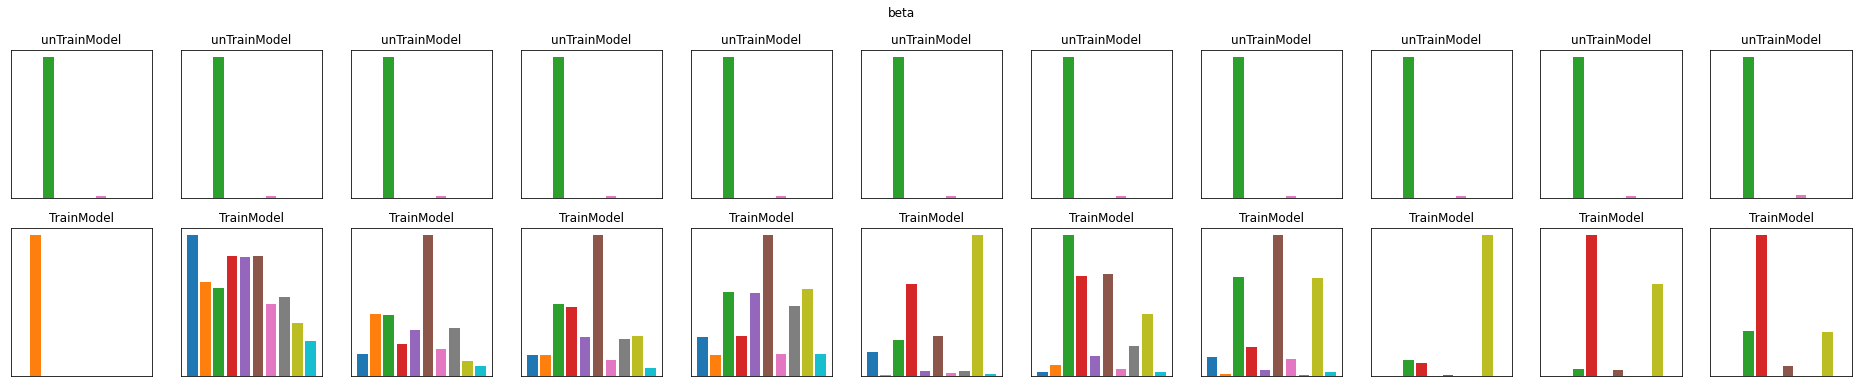

In [11]:
fig = plt.figure(figsize=(33, 6))
for i in tqdm.trange(11):
    TrainModel = MnistModel().cuda()
    optimizer = optim.Adam(TrainModel.parameters(), lr=1e-3)
    criterizion = nn.CrossEntropyLoss()
    epochs = 10
    for epoch in range(epochs):
        print('Epoch:{}'.format(epoch+1))
        beta_random_images = np.random.beta(a=1, b=1, size=x_train.shape)
        train_data = x_train*i*0.1+beta_random_images*(1-i*0.1)
        train_data = np.clip(0, 1, train_data)
        train(model=TrainModel, x=train_data, y=y_train, batch_size=128)
        test(model=TrainModel, x=x_test, y=y_test, batch_size=128)

    ax1 = fig.add_subplot(2, 11, i+1)
    ax2 = fig.add_subplot(2, 11, i+12)
    beta_random_images = np.random.beta(a=1, b=1, size=(10000, 1, 28, 28))
    beta_random_images = np.clip(0, 1, beta_random_images)
    draw_subfunction(unTrainModel, images=beta_random_images, plt_name='unTrainModel', ax=ax1)
    draw_subfunction(TrainModel, images=beta_random_images, plt_name='TrainModel', ax=ax2)
fig.suptitle('beta')
plt.show()

### uniform

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch:1
 Train Loss: 1079.5153 | Train Acc: 0.1124
 Test Acc:0.1028
Epoch:2
 Train Loss: 1079.3772 | Train Acc: 0.1123
 Test Acc:0.0598
Epoch:3
 Train Loss: 1079.3356 | Train Acc: 0.1123
 Test Acc:0.0587
Epoch:4
 Train Loss: 1079.3270 | Train Acc: 0.1119
 Test Acc:0.0960
Epoch:5
 Train Loss: 1079.3181 | Train Acc: 0.1120
 Test Acc:0.1134
Epoch:6
 Train Loss: 1079.3111 | Train Acc: 0.1119
 Test Acc:0.1135
Epoch:7
 Train Loss: 1079.3031 | Train Acc: 0.1125
 Test Acc:0.0824
Epoch:8
 Train Loss: 1079.3021 | Train Acc: 0.1122
 Test Acc:0.0582
Epoch:9
 Train Loss: 1079.3031 | Train Acc: 0.1121
 Test Acc:0.1135
Epoch:10
 Train Loss: 1079.2985 | Train Acc: 0.1124
 Test Acc:0.0438


  9%|▉         | 1/11 [00:18<03:04, 18.45s/it]

Epoch:1
 Train Loss: 934.9248 | Train Acc: 0.2838
 Test Acc:0.7887
Epoch:2
 Train Loss: 841.6530 | Train Acc: 0.3704
 Test Acc:0.8171
Epoch:3
 Train Loss: 832.3106 | Train Acc: 0.3807
 Test Acc:0.8355
Epoch:4
 Train Loss: 821.9735 | Train Acc: 0.3890
 Test Acc:0.8400
Epoch:5
 Train Loss: 814.3728 | Train Acc: 0.3940
 Test Acc:0.8445
Epoch:6
 Train Loss: 807.4041 | Train Acc: 0.4000
 Test Acc:0.8507
Epoch:7
 Train Loss: 795.1142 | Train Acc: 0.4090
 Test Acc:0.8471
Epoch:8
 Train Loss: 783.5581 | Train Acc: 0.4182
 Test Acc:0.8540
Epoch:9
 Train Loss: 763.6926 | Train Acc: 0.4343
 Test Acc:0.8559
Epoch:10
 Train Loss: 733.1399 | Train Acc: 0.4573
 Test Acc:0.8650


 18%|█▊        | 2/11 [00:36<02:45, 18.39s/it]

Epoch:1
 Train Loss: 646.7880 | Train Acc: 0.5278
 Test Acc:0.8553
Epoch:2
 Train Loss: 449.1415 | Train Acc: 0.6750
 Test Acc:0.9068
Epoch:3
 Train Loss: 407.6470 | Train Acc: 0.7052
 Test Acc:0.9251
Epoch:4
 Train Loss: 380.8332 | Train Acc: 0.7255
 Test Acc:0.9310
Epoch:5
 Train Loss: 362.2894 | Train Acc: 0.7400
 Test Acc:0.9342
Epoch:6
 Train Loss: 352.8145 | Train Acc: 0.7440
 Test Acc:0.9394
Epoch:7
 Train Loss: 343.0479 | Train Acc: 0.7500
 Test Acc:0.9409
Epoch:8
 Train Loss: 337.6849 | Train Acc: 0.7556
 Test Acc:0.9433
Epoch:9
 Train Loss: 331.3977 | Train Acc: 0.7600
 Test Acc:0.9450
Epoch:10
 Train Loss: 319.0319 | Train Acc: 0.7706
 Test Acc:0.9450


 27%|██▋       | 3/11 [00:55<02:27, 18.41s/it]

Epoch:1
 Train Loss: 512.7425 | Train Acc: 0.6398
 Test Acc:0.8348
Epoch:2
 Train Loss: 282.6415 | Train Acc: 0.8007
 Test Acc:0.8865
Epoch:3
 Train Loss: 227.3023 | Train Acc: 0.8415
 Test Acc:0.9103
Epoch:4
 Train Loss: 192.8737 | Train Acc: 0.8651
 Test Acc:0.9346
Epoch:5
 Train Loss: 169.0970 | Train Acc: 0.8819
 Test Acc:0.9388
Epoch:6
 Train Loss: 152.9310 | Train Acc: 0.8933
 Test Acc:0.9502
Epoch:7
 Train Loss: 142.2983 | Train Acc: 0.8998
 Test Acc:0.9545
Epoch:8
 Train Loss: 134.1257 | Train Acc: 0.9076
 Test Acc:0.9572
Epoch:9
 Train Loss: 129.5237 | Train Acc: 0.9091
 Test Acc:0.9604
Epoch:10
 Train Loss: 121.7387 | Train Acc: 0.9156
 Test Acc:0.9623


 36%|███▋      | 4/11 [01:13<02:08, 18.38s/it]

Epoch:1
 Train Loss: 373.5518 | Train Acc: 0.7412
 Test Acc:0.9188
Epoch:2
 Train Loss: 135.4198 | Train Acc: 0.9091
 Test Acc:0.9498
Epoch:3
 Train Loss: 103.5530 | Train Acc: 0.9295
 Test Acc:0.9625
Epoch:4
 Train Loss: 89.7956 | Train Acc: 0.9389
 Test Acc:0.9671
Epoch:5
 Train Loss: 81.2923 | Train Acc: 0.9449
 Test Acc:0.9703
Epoch:6
 Train Loss: 75.1142 | Train Acc: 0.9498
 Test Acc:0.9713
Epoch:7
 Train Loss: 70.9674 | Train Acc: 0.9512
 Test Acc:0.9746
Epoch:8
 Train Loss: 65.5821 | Train Acc: 0.9561
 Test Acc:0.9759
Epoch:9
 Train Loss: 62.0756 | Train Acc: 0.9568
 Test Acc:0.9792
Epoch:10
 Train Loss: 57.8106 | Train Acc: 0.9607
 Test Acc:0.9805


 45%|████▌     | 5/11 [01:31<01:49, 18.31s/it]

Epoch:1
 Train Loss: 329.7772 | Train Acc: 0.7813
 Test Acc:0.9095
Epoch:2
 Train Loss: 109.6904 | Train Acc: 0.9281
 Test Acc:0.9585
Epoch:3
 Train Loss: 78.2178 | Train Acc: 0.9487
 Test Acc:0.9682
Epoch:4
 Train Loss: 63.9603 | Train Acc: 0.9574
 Test Acc:0.9736
Epoch:5
 Train Loss: 54.9680 | Train Acc: 0.9634
 Test Acc:0.9780
Epoch:6
 Train Loss: 48.8216 | Train Acc: 0.9669
 Test Acc:0.9795
Epoch:7
 Train Loss: 45.5575 | Train Acc: 0.9692
 Test Acc:0.9797
Epoch:8
 Train Loss: 41.5249 | Train Acc: 0.9722
 Test Acc:0.9819
Epoch:9
 Train Loss: 38.5855 | Train Acc: 0.9742
 Test Acc:0.9834
Epoch:10
 Train Loss: 35.4657 | Train Acc: 0.9761
 Test Acc:0.9842


 55%|█████▍    | 6/11 [01:49<01:30, 18.20s/it]

Epoch:1
 Train Loss: 294.4345 | Train Acc: 0.8187
 Test Acc:0.8426
Epoch:2
 Train Loss: 106.4079 | Train Acc: 0.9307
 Test Acc:0.9106
Epoch:3
 Train Loss: 72.4669 | Train Acc: 0.9521
 Test Acc:0.9323
Epoch:4
 Train Loss: 57.7517 | Train Acc: 0.9620
 Test Acc:0.9502
Epoch:5
 Train Loss: 49.6604 | Train Acc: 0.9666
 Test Acc:0.9581
Epoch:6
 Train Loss: 44.6272 | Train Acc: 0.9700
 Test Acc:0.9693
Epoch:7
 Train Loss: 39.3661 | Train Acc: 0.9732
 Test Acc:0.9717
Epoch:8
 Train Loss: 36.2949 | Train Acc: 0.9757
 Test Acc:0.9758
Epoch:9
 Train Loss: 33.8197 | Train Acc: 0.9774
 Test Acc:0.9784
Epoch:10
 Train Loss: 31.4620 | Train Acc: 0.9789
 Test Acc:0.9809


 64%|██████▎   | 7/11 [02:07<01:12, 18.17s/it]

Epoch:1
 Train Loss: 267.2225 | Train Acc: 0.8344
 Test Acc:0.9201
Epoch:2
 Train Loss: 94.5639 | Train Acc: 0.9392
 Test Acc:0.9473
Epoch:3
 Train Loss: 65.1581 | Train Acc: 0.9572
 Test Acc:0.9577
Epoch:4
 Train Loss: 52.5540 | Train Acc: 0.9649
 Test Acc:0.9657
Epoch:5
 Train Loss: 43.8737 | Train Acc: 0.9709
 Test Acc:0.9693
Epoch:6
 Train Loss: 38.5914 | Train Acc: 0.9750
 Test Acc:0.9729
Epoch:7
 Train Loss: 34.2724 | Train Acc: 0.9777
 Test Acc:0.9763
Epoch:8
 Train Loss: 30.7216 | Train Acc: 0.9802
 Test Acc:0.9773
Epoch:9
 Train Loss: 27.9663 | Train Acc: 0.9812
 Test Acc:0.9799
Epoch:10
 Train Loss: 25.2999 | Train Acc: 0.9833
 Test Acc:0.9802


 73%|███████▎  | 8/11 [02:25<00:54, 18.13s/it]

Epoch:1
 Train Loss: 240.7233 | Train Acc: 0.8558
 Test Acc:0.9354
Epoch:2
 Train Loss: 81.3450 | Train Acc: 0.9480
 Test Acc:0.9593
Epoch:3
 Train Loss: 57.6001 | Train Acc: 0.9623
 Test Acc:0.9656
Epoch:4
 Train Loss: 46.4017 | Train Acc: 0.9691
 Test Acc:0.9710
Epoch:5
 Train Loss: 39.2620 | Train Acc: 0.9740
 Test Acc:0.9756
Epoch:6
 Train Loss: 33.6531 | Train Acc: 0.9778
 Test Acc:0.9760
Epoch:7
 Train Loss: 30.4130 | Train Acc: 0.9796
 Test Acc:0.9791
Epoch:8
 Train Loss: 27.1888 | Train Acc: 0.9817
 Test Acc:0.9799
Epoch:9
 Train Loss: 24.9220 | Train Acc: 0.9831
 Test Acc:0.9813
Epoch:10
 Train Loss: 22.2624 | Train Acc: 0.9851
 Test Acc:0.9814


 82%|████████▏ | 9/11 [02:43<00:36, 18.11s/it]

Epoch:1
 Train Loss: 227.1589 | Train Acc: 0.8638
 Test Acc:0.9536
Epoch:2
 Train Loss: 62.9431 | Train Acc: 0.9591
 Test Acc:0.9672
Epoch:3
 Train Loss: 43.7533 | Train Acc: 0.9719
 Test Acc:0.9719
Epoch:4
 Train Loss: 35.1160 | Train Acc: 0.9774
 Test Acc:0.9767
Epoch:5
 Train Loss: 29.5868 | Train Acc: 0.9808
 Test Acc:0.9785
Epoch:6
 Train Loss: 25.6846 | Train Acc: 0.9832
 Test Acc:0.9799
Epoch:7
 Train Loss: 22.7893 | Train Acc: 0.9854
 Test Acc:0.9813
Epoch:8
 Train Loss: 20.3112 | Train Acc: 0.9869
 Test Acc:0.9842
Epoch:9
 Train Loss: 18.1814 | Train Acc: 0.9880
 Test Acc:0.9836
Epoch:10
 Train Loss: 16.5574 | Train Acc: 0.9891
 Test Acc:0.9853


 91%|█████████ | 10/11 [03:01<00:18, 18.07s/it]

Epoch:1
 Train Loss: 238.4456 | Train Acc: 0.8520
 Test Acc:0.9501
Epoch:2
 Train Loss: 63.0073 | Train Acc: 0.9588
 Test Acc:0.9673
Epoch:3
 Train Loss: 44.8151 | Train Acc: 0.9708
 Test Acc:0.9742
Epoch:4
 Train Loss: 36.4675 | Train Acc: 0.9763
 Test Acc:0.9793
Epoch:5
 Train Loss: 30.8338 | Train Acc: 0.9796
 Test Acc:0.9817
Epoch:6
 Train Loss: 26.7429 | Train Acc: 0.9823
 Test Acc:0.9839
Epoch:7
 Train Loss: 23.9214 | Train Acc: 0.9842
 Test Acc:0.9833
Epoch:8
 Train Loss: 21.6998 | Train Acc: 0.9857
 Test Acc:0.9834
Epoch:9
 Train Loss: 19.5948 | Train Acc: 0.9873
 Test Acc:0.9838
Epoch:10
 Train Loss: 17.7595 | Train Acc: 0.9884
 Test Acc:0.9846


100%|██████████| 11/11 [03:19<00:00, 18.17s/it]


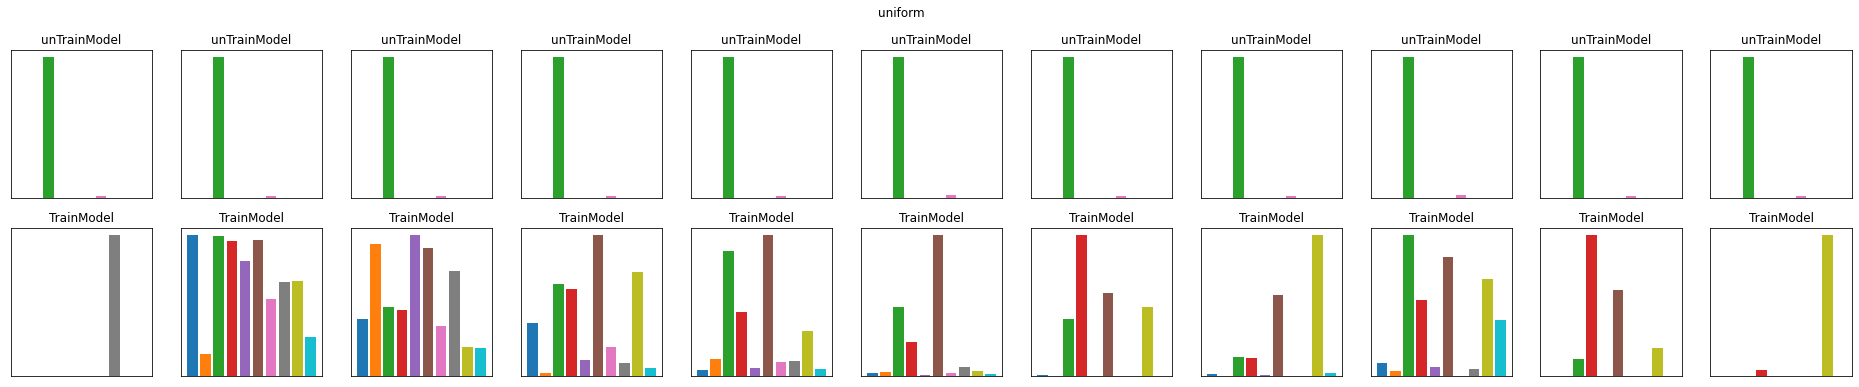

In [12]:
fig = plt.figure(figsize=(33, 6))
for i in tqdm.trange(11):
    TrainModel = MnistModel().cuda()
    optimizer = optim.Adam(TrainModel.parameters(), lr=1e-3)
    criterizion = nn.CrossEntropyLoss()
    epochs = 10
    for epoch in range(epochs):
        print('Epoch:{}'.format(epoch+1))
        uniform_random_images = np.random.uniform(low=0, high=1, size=x_train.shape)
        train_data = x_train*i*0.1+uniform_random_images*(1-i*0.1)
        train_data = np.clip(0, 1, train_data)
        train(model=TrainModel, x=train_data, y=y_train, batch_size=128)
        test(model=TrainModel, x=x_test, y=y_test, batch_size=128)

    ax1 = fig.add_subplot(2, 11, i+1)
    ax2 = fig.add_subplot(2, 11, i+12)
    uniform_random_images = np.random.uniform(low=0, high=1, size=(10000, 1, 28, 28))
    uniform_random_images = np.clip(0, 1, uniform_random_images)
    draw_subfunction(unTrainModel, images=uniform_random_images, plt_name='unTrainModel', ax=ax1)
    draw_subfunction(TrainModel, images=uniform_random_images, plt_name='TrainModel', ax=ax2)
fig.suptitle('uniform')
plt.show()

### weibull

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch:1
 Train Loss: 1079.3593 | Train Acc: 0.1123
 Test Acc:0.1028
Epoch:2
 Train Loss: 1079.3134 | Train Acc: 0.1121
 Test Acc:0.1048
Epoch:3
 Train Loss: 1079.3055 | Train Acc: 0.1119
 Test Acc:0.1575
Epoch:4
 Train Loss: 1079.3004 | Train Acc: 0.1124
 Test Acc:0.1160
Epoch:5
 Train Loss: 1079.2956 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:6
 Train Loss: 1079.2939 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:7
 Train Loss: 1079.2931 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:8
 Train Loss: 1079.2924 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:9
 Train Loss: 1079.2886 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:10
 Train Loss: 1079.2868 | Train Acc: 0.1124
 Test Acc:0.1135


  9%|▉         | 1/11 [00:58<09:41, 58.17s/it]

Epoch:1
 Train Loss: 891.2370 | Train Acc: 0.3074
 Test Acc:0.6627
Epoch:2
 Train Loss: 568.0673 | Train Acc: 0.5867
 Test Acc:0.7632
Epoch:3
 Train Loss: 460.0123 | Train Acc: 0.6650
 Test Acc:0.8144
Epoch:4
 Train Loss: 423.8270 | Train Acc: 0.6949
 Test Acc:0.8312
Epoch:5
 Train Loss: 396.1006 | Train Acc: 0.7145
 Test Acc:0.8625
Epoch:6
 Train Loss: 384.3184 | Train Acc: 0.7230
 Test Acc:0.8769
Epoch:7
 Train Loss: 369.3817 | Train Acc: 0.7333
 Test Acc:0.8852
Epoch:8
 Train Loss: 355.5687 | Train Acc: 0.7435
 Test Acc:0.8902
Epoch:9
 Train Loss: 345.2436 | Train Acc: 0.7513
 Test Acc:0.9113
Epoch:10
 Train Loss: 341.3934 | Train Acc: 0.7521
 Test Acc:0.9110


 18%|█▊        | 2/11 [01:55<08:37, 57.51s/it]

Epoch:1
 Train Loss: 484.5416 | Train Acc: 0.6732
 Test Acc:0.8518
Epoch:2
 Train Loss: 198.1635 | Train Acc: 0.8676
 Test Acc:0.9189
Epoch:3
 Train Loss: 147.1794 | Train Acc: 0.9004
 Test Acc:0.9375
Epoch:4
 Train Loss: 123.0029 | Train Acc: 0.9172
 Test Acc:0.9542
Epoch:5
 Train Loss: 106.5488 | Train Acc: 0.9277
 Test Acc:0.9595
Epoch:6
 Train Loss: 96.6811 | Train Acc: 0.9337
 Test Acc:0.9637
Epoch:7
 Train Loss: 87.5660 | Train Acc: 0.9405
 Test Acc:0.9670
Epoch:8
 Train Loss: 81.9746 | Train Acc: 0.9433
 Test Acc:0.9700
Epoch:9
 Train Loss: 77.6597 | Train Acc: 0.9471
 Test Acc:0.9729
Epoch:10
 Train Loss: 73.0689 | Train Acc: 0.9495
 Test Acc:0.9740


 27%|██▋       | 3/11 [02:52<07:38, 57.27s/it]

Epoch:1
 Train Loss: 468.6935 | Train Acc: 0.6838
 Test Acc:0.8501
Epoch:2
 Train Loss: 190.6507 | Train Acc: 0.8758
 Test Acc:0.9057
Epoch:3
 Train Loss: 131.3589 | Train Acc: 0.9150
 Test Acc:0.9319
Epoch:4
 Train Loss: 102.1731 | Train Acc: 0.9319
 Test Acc:0.9448
Epoch:5
 Train Loss: 86.6291 | Train Acc: 0.9413
 Test Acc:0.9524
Epoch:6
 Train Loss: 77.4672 | Train Acc: 0.9477
 Test Acc:0.9579
Epoch:7
 Train Loss: 71.1603 | Train Acc: 0.9517
 Test Acc:0.9615
Epoch:8
 Train Loss: 66.4719 | Train Acc: 0.9545
 Test Acc:0.9639
Epoch:9
 Train Loss: 61.8158 | Train Acc: 0.9576
 Test Acc:0.9663
Epoch:10
 Train Loss: 57.5116 | Train Acc: 0.9602
 Test Acc:0.9693


 36%|███▋      | 4/11 [03:49<06:41, 57.42s/it]

Epoch:1
 Train Loss: 414.9509 | Train Acc: 0.7278
 Test Acc:0.8854
Epoch:2
 Train Loss: 139.9019 | Train Acc: 0.9111
 Test Acc:0.9216
Epoch:3
 Train Loss: 98.5714 | Train Acc: 0.9364
 Test Acc:0.9375
Epoch:4
 Train Loss: 80.4844 | Train Acc: 0.9470
 Test Acc:0.9554
Epoch:5
 Train Loss: 68.4710 | Train Acc: 0.9547
 Test Acc:0.9615
Epoch:6
 Train Loss: 59.4774 | Train Acc: 0.9612
 Test Acc:0.9676
Epoch:7
 Train Loss: 53.8794 | Train Acc: 0.9638
 Test Acc:0.9694
Epoch:8
 Train Loss: 49.2826 | Train Acc: 0.9672
 Test Acc:0.9717
Epoch:9
 Train Loss: 46.9526 | Train Acc: 0.9686
 Test Acc:0.9721
Epoch:10
 Train Loss: 42.8827 | Train Acc: 0.9710
 Test Acc:0.9736


 45%|████▌     | 5/11 [04:46<05:42, 57.12s/it]

Epoch:1
 Train Loss: 357.7986 | Train Acc: 0.7608
 Test Acc:0.7863
Epoch:2
 Train Loss: 125.9392 | Train Acc: 0.9178
 Test Acc:0.8808
Epoch:3
 Train Loss: 89.6196 | Train Acc: 0.9419
 Test Acc:0.9253
Epoch:4
 Train Loss: 70.5558 | Train Acc: 0.9540
 Test Acc:0.9395
Epoch:5
 Train Loss: 59.1871 | Train Acc: 0.9621
 Test Acc:0.9536
Epoch:6
 Train Loss: 51.9443 | Train Acc: 0.9660
 Test Acc:0.9599
Epoch:7
 Train Loss: 46.5871 | Train Acc: 0.9690
 Test Acc:0.9656
Epoch:8
 Train Loss: 42.8792 | Train Acc: 0.9718
 Test Acc:0.9701
Epoch:9
 Train Loss: 39.7484 | Train Acc: 0.9742
 Test Acc:0.9736
Epoch:10
 Train Loss: 37.1942 | Train Acc: 0.9754
 Test Acc:0.9761


 55%|█████▍    | 6/11 [05:43<04:44, 56.94s/it]

Epoch:1
 Train Loss: 281.6625 | Train Acc: 0.8295
 Test Acc:0.8662
Epoch:2
 Train Loss: 103.0166 | Train Acc: 0.9338
 Test Acc:0.9298
Epoch:3
 Train Loss: 72.9772 | Train Acc: 0.9536
 Test Acc:0.9493
Epoch:4
 Train Loss: 58.1134 | Train Acc: 0.9622
 Test Acc:0.9543
Epoch:5
 Train Loss: 49.3478 | Train Acc: 0.9677
 Test Acc:0.9594
Epoch:6
 Train Loss: 43.1143 | Train Acc: 0.9718
 Test Acc:0.9635
Epoch:7
 Train Loss: 38.4439 | Train Acc: 0.9751
 Test Acc:0.9678
Epoch:8
 Train Loss: 34.2971 | Train Acc: 0.9774
 Test Acc:0.9664
Epoch:9
 Train Loss: 31.7713 | Train Acc: 0.9790
 Test Acc:0.9669
Epoch:10
 Train Loss: 29.3611 | Train Acc: 0.9799
 Test Acc:0.9669


 64%|██████▎   | 7/11 [06:39<03:47, 56.88s/it]

Epoch:1
 Train Loss: 297.8164 | Train Acc: 0.8188
 Test Acc:0.9085
Epoch:2
 Train Loss: 99.2482 | Train Acc: 0.9369
 Test Acc:0.9553
Epoch:3
 Train Loss: 64.8109 | Train Acc: 0.9579
 Test Acc:0.9653
Epoch:4
 Train Loss: 50.3001 | Train Acc: 0.9671
 Test Acc:0.9704
Epoch:5
 Train Loss: 42.2531 | Train Acc: 0.9719
 Test Acc:0.9743
Epoch:6
 Train Loss: 36.8499 | Train Acc: 0.9754
 Test Acc:0.9760
Epoch:7
 Train Loss: 32.7058 | Train Acc: 0.9783
 Test Acc:0.9771
Epoch:8
 Train Loss: 29.6143 | Train Acc: 0.9802
 Test Acc:0.9763
Epoch:9
 Train Loss: 26.7908 | Train Acc: 0.9825
 Test Acc:0.9763
Epoch:10
 Train Loss: 24.7552 | Train Acc: 0.9834
 Test Acc:0.9779


 73%|███████▎  | 8/11 [07:36<02:50, 56.79s/it]

Epoch:1
 Train Loss: 263.6201 | Train Acc: 0.8322
 Test Acc:0.9153
Epoch:2
 Train Loss: 86.7696 | Train Acc: 0.9440
 Test Acc:0.9509
Epoch:3
 Train Loss: 58.0367 | Train Acc: 0.9617
 Test Acc:0.9656
Epoch:4
 Train Loss: 45.4228 | Train Acc: 0.9696
 Test Acc:0.9727
Epoch:5
 Train Loss: 37.8819 | Train Acc: 0.9744
 Test Acc:0.9768
Epoch:6
 Train Loss: 32.7617 | Train Acc: 0.9777
 Test Acc:0.9791
Epoch:7
 Train Loss: 28.6788 | Train Acc: 0.9805
 Test Acc:0.9810
Epoch:8
 Train Loss: 25.3637 | Train Acc: 0.9829
 Test Acc:0.9815
Epoch:9
 Train Loss: 22.9367 | Train Acc: 0.9847
 Test Acc:0.9819
Epoch:10
 Train Loss: 20.8955 | Train Acc: 0.9865
 Test Acc:0.9836


 82%|████████▏ | 9/11 [08:32<01:53, 56.70s/it]

Epoch:1
 Train Loss: 256.0793 | Train Acc: 0.8377
 Test Acc:0.9262
Epoch:2
 Train Loss: 80.0378 | Train Acc: 0.9485
 Test Acc:0.9579
Epoch:3
 Train Loss: 51.9365 | Train Acc: 0.9658
 Test Acc:0.9691
Epoch:4
 Train Loss: 39.9278 | Train Acc: 0.9739
 Test Acc:0.9733
Epoch:5
 Train Loss: 33.2578 | Train Acc: 0.9779
 Test Acc:0.9762
Epoch:6
 Train Loss: 28.6544 | Train Acc: 0.9808
 Test Acc:0.9783
Epoch:7
 Train Loss: 25.2958 | Train Acc: 0.9834
 Test Acc:0.9810
Epoch:8
 Train Loss: 22.4916 | Train Acc: 0.9853
 Test Acc:0.9818
Epoch:9
 Train Loss: 20.1173 | Train Acc: 0.9867
 Test Acc:0.9815
Epoch:10
 Train Loss: 18.1759 | Train Acc: 0.9884
 Test Acc:0.9809


 91%|█████████ | 10/11 [09:29<00:56, 56.78s/it]

Epoch:1
 Train Loss: 221.8377 | Train Acc: 0.8690
 Test Acc:0.9467
Epoch:2
 Train Loss: 70.6097 | Train Acc: 0.9545
 Test Acc:0.9673
Epoch:3
 Train Loss: 47.5232 | Train Acc: 0.9692
 Test Acc:0.9723
Epoch:4
 Train Loss: 37.5367 | Train Acc: 0.9750
 Test Acc:0.9750
Epoch:5
 Train Loss: 31.5867 | Train Acc: 0.9787
 Test Acc:0.9780
Epoch:6
 Train Loss: 27.2416 | Train Acc: 0.9819
 Test Acc:0.9801
Epoch:7
 Train Loss: 23.9497 | Train Acc: 0.9840
 Test Acc:0.9816
Epoch:8
 Train Loss: 21.1828 | Train Acc: 0.9858
 Test Acc:0.9816
Epoch:9
 Train Loss: 18.9349 | Train Acc: 0.9875
 Test Acc:0.9809
Epoch:10
 Train Loss: 16.9457 | Train Acc: 0.9889
 Test Acc:0.9827


100%|██████████| 11/11 [10:26<00:00, 56.96s/it]


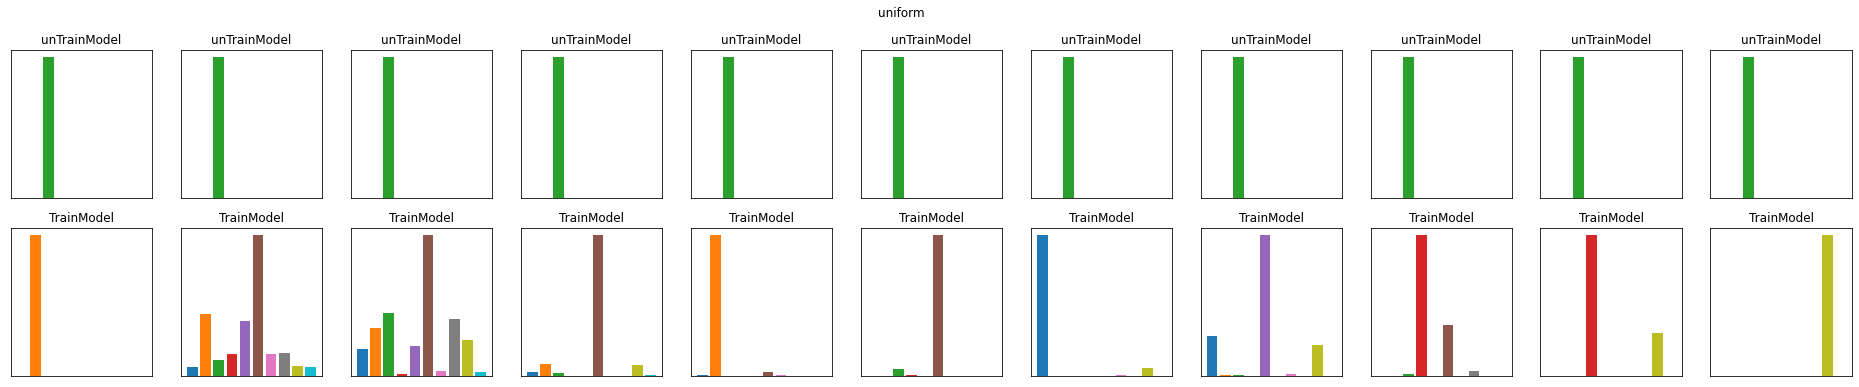

In [14]:
fig = plt.figure(figsize=(33, 6))
for i in tqdm.trange(11):
    TrainModel = MnistModel().cuda()
    optimizer = optim.Adam(TrainModel.parameters(), lr=1e-3)
    criterizion = nn.CrossEntropyLoss()
    epochs = 10
    for epoch in range(epochs):
        print('Epoch:{}'.format(epoch+1))
        weibull_random_images = np.random.weibull(a=10, size=x_train.shape)
        train_data = x_train*i*0.1+weibull_random_images*(1-i*0.1)
        train_data = np.clip(0, 1, train_data)
        train(model=TrainModel, x=train_data, y=y_train, batch_size=128)
        test(model=TrainModel, x=x_test, y=y_test, batch_size=128)

    ax1 = fig.add_subplot(2, 11, i+1)
    ax2 = fig.add_subplot(2, 11, i+12)
    weibull_random_images = np.random.weibull(a=10, size=(10000, 1, 28, 28))
    weibull_random_images = np.clip(0, 1, weibull_random_images)
    draw_subfunction(unTrainModel, images=weibull_random_images, plt_name='unTrainModel', ax=ax1)
    draw_subfunction(TrainModel, images=weibull_random_images, plt_name='TrainModel', ax=ax2)
fig.suptitle('uniform')
plt.show()

### dirichlet

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch:1
 Train Loss: 1079.3539 | Train Acc: 0.1121
 Test Acc:0.0928
Epoch:2
 Train Loss: 1079.3190 | Train Acc: 0.1120
 Test Acc:0.1113
Epoch:3
 Train Loss: 1079.3142 | Train Acc: 0.1121
 Test Acc:0.1139
Epoch:4
 Train Loss: 1079.3112 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:5
 Train Loss: 1079.3067 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:6
 Train Loss: 1079.3030 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:7
 Train Loss: 1079.3003 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:8
 Train Loss: 1079.2986 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:9
 Train Loss: 1079.2954 | Train Acc: 0.1124
 Test Acc:0.1135
Epoch:10
 Train Loss: 1079.2941 | Train Acc: 0.1124
 Test Acc:0.1135


  9%|▉         | 1/11 [00:35<05:59, 35.97s/it]

Epoch:1
 Train Loss: 824.2294 | Train Acc: 0.3759
 Test Acc:0.6641
Epoch:2
 Train Loss: 283.3510 | Train Acc: 0.8129
 Test Acc:0.8024
Epoch:3
 Train Loss: 221.7174 | Train Acc: 0.8573
 Test Acc:0.8448
Epoch:4
 Train Loss: 186.6186 | Train Acc: 0.8812
 Test Acc:0.8688
Epoch:5
 Train Loss: 158.8166 | Train Acc: 0.8979
 Test Acc:0.8849
Epoch:6
 Train Loss: 139.0605 | Train Acc: 0.9107
 Test Acc:0.8982
Epoch:7
 Train Loss: 124.6739 | Train Acc: 0.9192
 Test Acc:0.9061
Epoch:8
 Train Loss: 112.4542 | Train Acc: 0.9275
 Test Acc:0.9141
Epoch:9
 Train Loss: 103.1526 | Train Acc: 0.9338
 Test Acc:0.9223
Epoch:10
 Train Loss: 95.5620 | Train Acc: 0.9376
 Test Acc:0.9256


 18%|█▊        | 2/11 [01:11<05:21, 35.71s/it]

Epoch:1
 Train Loss: 473.9231 | Train Acc: 0.6719
 Test Acc:0.7665
Epoch:2
 Train Loss: 183.5678 | Train Acc: 0.8810
 Test Acc:0.8662
Epoch:3
 Train Loss: 133.2631 | Train Acc: 0.9130
 Test Acc:0.8981
Epoch:4
 Train Loss: 106.4074 | Train Acc: 0.9298
 Test Acc:0.9152
Epoch:5
 Train Loss: 91.6406 | Train Acc: 0.9384
 Test Acc:0.9275
Epoch:6
 Train Loss: 81.3365 | Train Acc: 0.9452
 Test Acc:0.9349
Epoch:7
 Train Loss: 73.6255 | Train Acc: 0.9504
 Test Acc:0.9392
Epoch:8
 Train Loss: 67.5842 | Train Acc: 0.9541
 Test Acc:0.9413
Epoch:9
 Train Loss: 62.4813 | Train Acc: 0.9572
 Test Acc:0.9454
Epoch:10
 Train Loss: 58.2839 | Train Acc: 0.9606
 Test Acc:0.9472


 27%|██▋       | 3/11 [01:47<04:47, 35.96s/it]

Epoch:1
 Train Loss: 466.6160 | Train Acc: 0.6931
 Test Acc:0.7943
Epoch:2
 Train Loss: 201.5746 | Train Acc: 0.8719
 Test Acc:0.8778
Epoch:3
 Train Loss: 152.1270 | Train Acc: 0.9035
 Test Acc:0.8993
Epoch:4
 Train Loss: 127.1748 | Train Acc: 0.9184
 Test Acc:0.9090
Epoch:5
 Train Loss: 111.9382 | Train Acc: 0.9271
 Test Acc:0.9121
Epoch:6
 Train Loss: 101.4340 | Train Acc: 0.9337
 Test Acc:0.9166
Epoch:7
 Train Loss: 93.5181 | Train Acc: 0.9387
 Test Acc:0.9177
Epoch:8
 Train Loss: 86.8507 | Train Acc: 0.9422
 Test Acc:0.9208
Epoch:9
 Train Loss: 81.2643 | Train Acc: 0.9462
 Test Acc:0.9233
Epoch:10
 Train Loss: 76.5522 | Train Acc: 0.9491
 Test Acc:0.9269


 36%|███▋      | 4/11 [02:23<04:10, 35.81s/it]

Epoch:1
 Train Loss: 370.6485 | Train Acc: 0.7666
 Test Acc:0.8802
Epoch:2
 Train Loss: 138.4341 | Train Acc: 0.9116
 Test Acc:0.9365
Epoch:3
 Train Loss: 94.9398 | Train Acc: 0.9386
 Test Acc:0.9510
Epoch:4
 Train Loss: 72.7998 | Train Acc: 0.9530
 Test Acc:0.9598
Epoch:5
 Train Loss: 59.6515 | Train Acc: 0.9617
 Test Acc:0.9654
Epoch:6
 Train Loss: 51.4273 | Train Acc: 0.9663
 Test Acc:0.9679
Epoch:7
 Train Loss: 45.9006 | Train Acc: 0.9698
 Test Acc:0.9690
Epoch:8
 Train Loss: 41.5934 | Train Acc: 0.9730
 Test Acc:0.9706
Epoch:9
 Train Loss: 38.2457 | Train Acc: 0.9751
 Test Acc:0.9719
Epoch:10
 Train Loss: 35.2549 | Train Acc: 0.9774
 Test Acc:0.9739


 45%|████▌     | 5/11 [02:57<03:30, 35.16s/it]

Epoch:1
 Train Loss: 340.2324 | Train Acc: 0.7796
 Test Acc:0.8589
Epoch:2
 Train Loss: 111.2954 | Train Acc: 0.9276
 Test Acc:0.9117
Epoch:3
 Train Loss: 79.0682 | Train Acc: 0.9480
 Test Acc:0.9387
Epoch:4
 Train Loss: 62.5448 | Train Acc: 0.9587
 Test Acc:0.9495
Epoch:5
 Train Loss: 52.6748 | Train Acc: 0.9652
 Test Acc:0.9572
Epoch:6
 Train Loss: 45.7301 | Train Acc: 0.9694
 Test Acc:0.9631
Epoch:7
 Train Loss: 40.6609 | Train Acc: 0.9732
 Test Acc:0.9685
Epoch:8
 Train Loss: 36.6073 | Train Acc: 0.9758
 Test Acc:0.9708
Epoch:9
 Train Loss: 33.2839 | Train Acc: 0.9778
 Test Acc:0.9720
Epoch:10
 Train Loss: 30.6108 | Train Acc: 0.9797
 Test Acc:0.9731


 55%|█████▍    | 6/11 [03:31<02:53, 34.76s/it]

Epoch:1
 Train Loss: 302.8932 | Train Acc: 0.8063
 Test Acc:0.9174
Epoch:2
 Train Loss: 99.4984 | Train Acc: 0.9355
 Test Acc:0.9479
Epoch:3
 Train Loss: 69.1497 | Train Acc: 0.9546
 Test Acc:0.9588
Epoch:4
 Train Loss: 55.1131 | Train Acc: 0.9633
 Test Acc:0.9638
Epoch:5
 Train Loss: 46.7478 | Train Acc: 0.9690
 Test Acc:0.9661
Epoch:6
 Train Loss: 41.1106 | Train Acc: 0.9735
 Test Acc:0.9695
Epoch:7
 Train Loss: 36.9986 | Train Acc: 0.9763
 Test Acc:0.9715
Epoch:8
 Train Loss: 33.5632 | Train Acc: 0.9786
 Test Acc:0.9725
Epoch:9
 Train Loss: 30.7543 | Train Acc: 0.9800
 Test Acc:0.9728
Epoch:10
 Train Loss: 28.5133 | Train Acc: 0.9813
 Test Acc:0.9739


 64%|██████▎   | 7/11 [04:05<02:18, 34.62s/it]

Epoch:1
 Train Loss: 276.1754 | Train Acc: 0.8302
 Test Acc:0.9316
Epoch:2
 Train Loss: 78.4170 | Train Acc: 0.9497
 Test Acc:0.9520
Epoch:3
 Train Loss: 54.3608 | Train Acc: 0.9644
 Test Acc:0.9617
Epoch:4
 Train Loss: 43.2281 | Train Acc: 0.9715
 Test Acc:0.9669
Epoch:5
 Train Loss: 36.5914 | Train Acc: 0.9760
 Test Acc:0.9703
Epoch:6
 Train Loss: 31.9235 | Train Acc: 0.9787
 Test Acc:0.9728
Epoch:7
 Train Loss: 28.2711 | Train Acc: 0.9812
 Test Acc:0.9750
Epoch:8
 Train Loss: 25.3872 | Train Acc: 0.9833
 Test Acc:0.9755
Epoch:9
 Train Loss: 23.0792 | Train Acc: 0.9847
 Test Acc:0.9763
Epoch:10
 Train Loss: 20.9786 | Train Acc: 0.9859
 Test Acc:0.9772


 73%|███████▎  | 8/11 [04:43<01:46, 35.60s/it]

Epoch:1
 Train Loss: 228.3271 | Train Acc: 0.8640
 Test Acc:0.9421
Epoch:2
 Train Loss: 71.1059 | Train Acc: 0.9550
 Test Acc:0.9632
Epoch:3
 Train Loss: 50.0040 | Train Acc: 0.9683
 Test Acc:0.9697
Epoch:4
 Train Loss: 40.1054 | Train Acc: 0.9743
 Test Acc:0.9735
Epoch:5
 Train Loss: 33.9188 | Train Acc: 0.9784
 Test Acc:0.9782
Epoch:6
 Train Loss: 29.5774 | Train Acc: 0.9809
 Test Acc:0.9808
Epoch:7
 Train Loss: 26.2797 | Train Acc: 0.9830
 Test Acc:0.9814
Epoch:8
 Train Loss: 23.6287 | Train Acc: 0.9848
 Test Acc:0.9822
Epoch:9
 Train Loss: 21.4479 | Train Acc: 0.9861
 Test Acc:0.9831
Epoch:10
 Train Loss: 19.3431 | Train Acc: 0.9873
 Test Acc:0.9838


 82%|████████▏ | 9/11 [05:17<01:10, 35.24s/it]

Epoch:1
 Train Loss: 284.2788 | Train Acc: 0.8155
 Test Acc:0.8975
Epoch:2
 Train Loss: 91.3404 | Train Acc: 0.9408
 Test Acc:0.9473
Epoch:3
 Train Loss: 59.6541 | Train Acc: 0.9616
 Test Acc:0.9600
Epoch:4
 Train Loss: 46.0618 | Train Acc: 0.9705
 Test Acc:0.9678
Epoch:5
 Train Loss: 38.1709 | Train Acc: 0.9759
 Test Acc:0.9723
Epoch:6
 Train Loss: 32.7966 | Train Acc: 0.9791
 Test Acc:0.9747
Epoch:7
 Train Loss: 28.8808 | Train Acc: 0.9813
 Test Acc:0.9746
Epoch:8
 Train Loss: 26.0679 | Train Acc: 0.9834
 Test Acc:0.9756
Epoch:9
 Train Loss: 23.7091 | Train Acc: 0.9847
 Test Acc:0.9765
Epoch:10
 Train Loss: 21.5949 | Train Acc: 0.9862
 Test Acc:0.9775


 91%|█████████ | 10/11 [05:51<00:34, 34.88s/it]

Epoch:1
 Train Loss: 213.8792 | Train Acc: 0.8702
 Test Acc:0.9505
Epoch:2
 Train Loss: 65.0193 | Train Acc: 0.9582
 Test Acc:0.9660
Epoch:3
 Train Loss: 45.0230 | Train Acc: 0.9711
 Test Acc:0.9718
Epoch:4
 Train Loss: 35.8452 | Train Acc: 0.9764
 Test Acc:0.9788
Epoch:5
 Train Loss: 29.9110 | Train Acc: 0.9807
 Test Acc:0.9809
Epoch:6
 Train Loss: 25.5734 | Train Acc: 0.9833
 Test Acc:0.9821
Epoch:7
 Train Loss: 22.4180 | Train Acc: 0.9855
 Test Acc:0.9831
Epoch:8
 Train Loss: 19.6128 | Train Acc: 0.9874
 Test Acc:0.9835
Epoch:9
 Train Loss: 17.4271 | Train Acc: 0.9886
 Test Acc:0.9845
Epoch:10
 Train Loss: 15.7645 | Train Acc: 0.9898
 Test Acc:0.9838


100%|██████████| 11/11 [06:25<00:00, 35.06s/it]


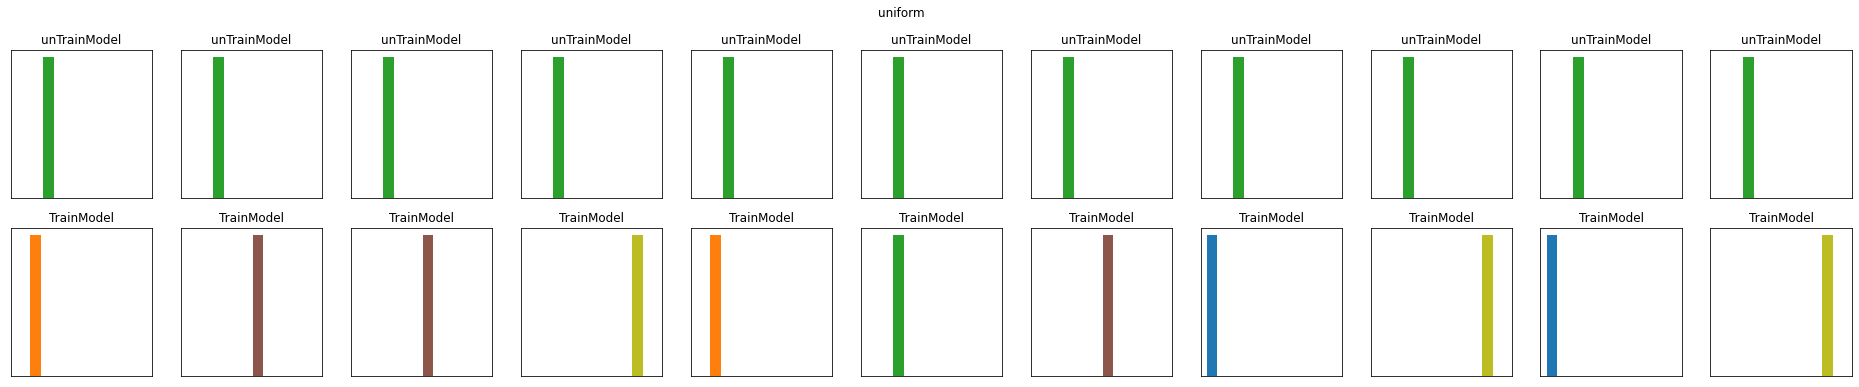

In [22]:
fig = plt.figure(figsize=(33, 6))
for i in tqdm.trange(11):
    TrainModel = MnistModel().cuda()
    optimizer = optim.Adam(TrainModel.parameters(), lr=1e-3)
    criterizion = nn.CrossEntropyLoss()
    epochs = 10
    for epoch in range(epochs):
        print('Epoch:{}'.format(epoch+1))
        dirichlet_random_images = np.random.dirichlet(([1]), size=x_train.shape).reshape((-1, 28, 28, 1))
        train_data = x_train*i*0.1+dirichlet_random_images*(1-i*0.1)
        train_data = np.clip(0, 1, train_data)
        train(model=TrainModel, x=train_data, y=y_train, batch_size=128)
        test(model=TrainModel, x=x_test, y=y_test, batch_size=128)

    ax1 = fig.add_subplot(2, 11, i+1)
    ax2 = fig.add_subplot(2, 11, i+12)
    dirichlet_random_images = np.random.dirichlet(([1]), size=(10000, 1, 28, 28)).reshape((10000, 1, 28, 28))
    dirichlet_random_images = np.clip(0, 1, dirichlet_random_images)
    draw_subfunction(unTrainModel, images=dirichlet_random_images, plt_name='unTrainModel', ax=ax1)
    draw_subfunction(TrainModel, images=dirichlet_random_images, plt_name='TrainModel', ax=ax2)
fig.suptitle('uniform')
plt.show()


*Question 3*: **Are other models are same as MNIST Model**

- Evaluate on different models including "AlexNet", "ResNet", "VGG"

*Answer 3*: Yes! they are all out of performance!!!

 ### generate random images

In [4]:
image_shape = (10000, 3, 224, 224)
# gaussian
gaussian_random_images = np.random.randn(*image_shape)/6+0.5
gaussian_random_images = np.clip(0, 1, gaussian_random_images)

# beta
beta_random_images = np.random.beta(a=1, b=1, size=image_shape)
beta_random_images = np.clip(0, 1, beta_random_images)

# uniform
uniform_random_images = np.random.uniform(low=1, high=1, size=image_shape)
uniform_random_images = np.clip(0, 1, uniform_random_images)

# weibull
weibull_random_images = np.random.weibull(a=10, size=image_shape)
weibull_random_images = np.clip(0, 1, weibull_random_images)

# dirichlet
dirichlet_random_images = np.random.dirichlet(([1]), size=image_shape).reshape(image_shape)
dirichlet_random_images = np.clip(0, 1, dirichlet_random_images)


random_images = [gaussian_random_images, beta_random_images, uniform_random_images,
                 weibull_random_images, dirichlet_random_images]
noise_name = ['gaussian', 'beta', 'uniform', 'weibull', 'dirichlet']

###  AlexNet

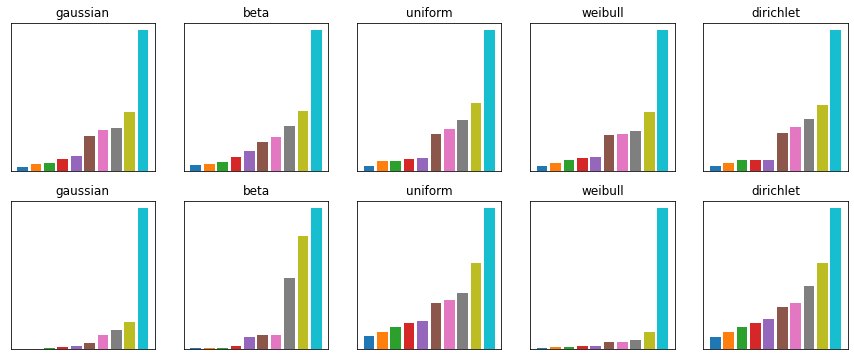

In [52]:
from torchvision.models import alexnet

AlexNet_unTrainModel = alexnet(pretrained=False).cuda()
AlexNet_TrainModel = alexnet(pretrained=False).cuda()
model_path = '/home/nvidia/LINMUX/Pretrained models/torch/Alex/alexnet-owt-4df8aa71.pth'
AlexNet_TrainModel.load_state_dict(torch.load(model_path))

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    ax1 = fig.add_subplot(2, 5, i+1)
    ax2 = fig.add_subplot(2, 5, i+6)
    draw_subfunction(model=AlexNet_unTrainModel, images=random_images[i], 
                        plt_name=noise_name[i], ax=ax1, batch_size=32, num_classes=1000)
    draw_subfunction(model=AlexNet_TrainModel, images=random_images[i], 
                        plt_name=noise_name[i], ax=ax2, batch_size=32, num_classes=1000)
plt.show()

### ResNet

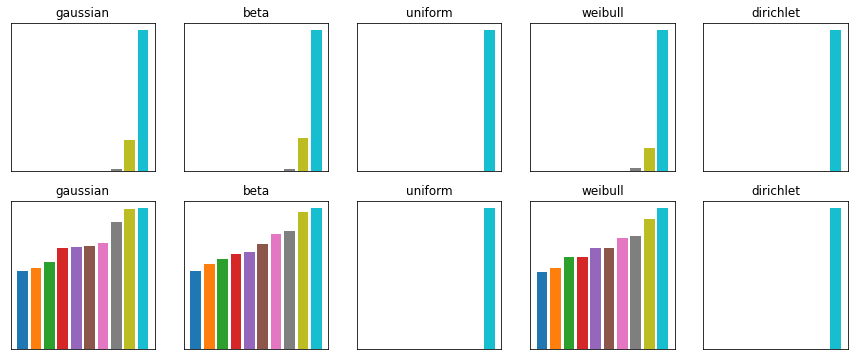

In [53]:
from torchvision.models import resnet101

ResNet_unTrainModel = resnet101(pretrained=False).cuda()
ResNet_TrainModel = resnet101(pretrained=False).cuda()
model_path = '/home/nvidia/LINMUX/Pretrained models/torch/ResNet/resnet101-5d3b4d8f.pth'
ResNet_TrainModel.load_state_dict(torch.load(model_path))

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    ax1 = fig.add_subplot(2, 5, i+1)
    ax2 = fig.add_subplot(2, 5, i+6)
    draw_subfunction(model=ResNet_unTrainModel, images=random_images[i], 
                        plt_name=noise_name[i], ax=ax1, batch_size=32, num_classes=1000)
    draw_subfunction(model=ResNet_TrainModel, images=random_images[i], 
                        plt_name=noise_name[i], ax=ax2, batch_size=32, num_classes=1000)
plt.show()

### VGG

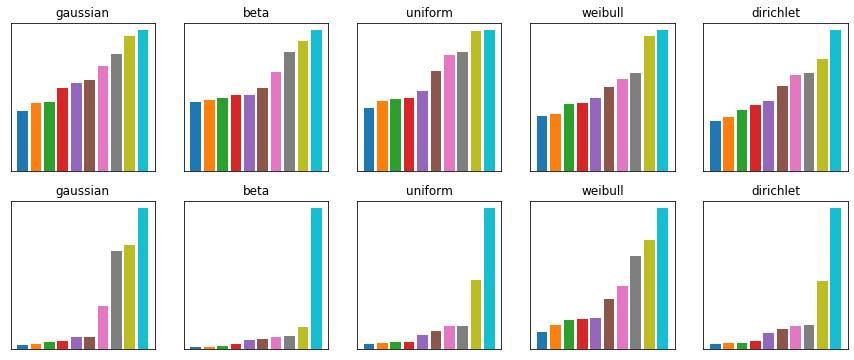

In [5]:
from torchvision.models import vgg16

VGG_unTrainModel = vgg16(pretrained=False).cuda()
VGG_TrainModel = vgg16(pretrained=False).cuda()
model_path = '/home/nvidia/LINMUX/Pretrained models/torch/VGG/vgg16-397923af.pth'
VGG_TrainModel.load_state_dict(torch.load(model_path))

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    ax1 = fig.add_subplot(2, 5, i+1)
    ax2 = fig.add_subplot(2, 5, i+6)
    draw_subfunction(model=VGG_unTrainModel, images=random_images[i], 
                        plt_name=noise_name[i], ax=ax1, batch_size=32, num_classes=1000)
    draw_subfunction(model=VGG_TrainModel, images=random_images[i], 
                        plt_name=noise_name[i], ax=ax2, batch_size=32, num_classes=1000)
plt.show()

*Question 4* : Is the reason that these noises are similar to the data of one category when the random noises are mainly classified into one category?

- step1: compute the ssmi, mse or any others
- step2: evaluate

*Answer 4*: **NO!!!**

In [9]:
from skimage.measure import compare_mse, compare_psnr, compare_ssim
example_images = [x_train[y_train==i][0] for i in range(10)]# Test on MNIST

# gaussian
gaussian_random_images = np.random.randn(10000, 1, 28, 28)/6+0.5
gaussian_random_images = np.clip(0, 1, gaussian_random_images)

# beta
beta_random_images = np.random.beta(a=1, b=1, size=(10000, 1, 28, 28))
beta_random_images = np.clip(0, 1, beta_random_images)

# uniform
uniform_random_images = np.random.uniform(low=1, high=1, size=(10000, 1, 28, 28))
uniform_random_images = np.clip(0, 1, uniform_random_images)

# weibull
weibull_random_images = np.random.weibull(a=10, size=(10000, 1, 28, 28))
weibull_random_images = np.clip(0, 1, weibull_random_images)

# dirichlet
dirichlet_random_images = np.random.dirichlet(([1]), size=(10000, 1, 28, 28)).reshape((10000, 1, 28, 28))
dirichlet_random_images = np.clip(0, 1, dirichlet_random_images)

random_images = [gaussian_random_images, beta_random_images, uniform_random_images,
                 weibull_random_images, dirichlet_random_images]
noise_name = ['gaussian', 'beta', 'uniform', 'weibull', 'dirichlet']

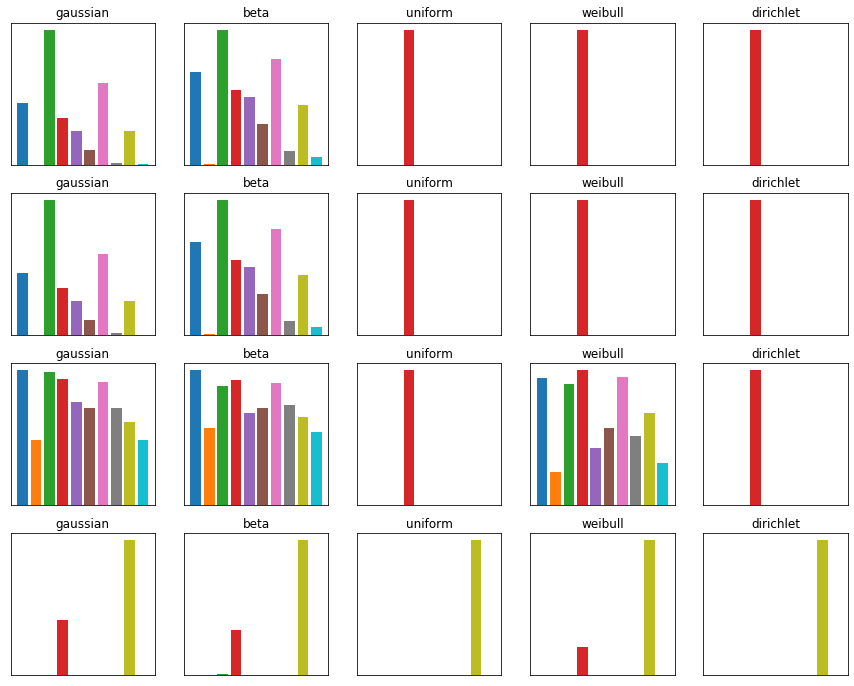

In [50]:
def compute_similarity(example_images, x, compare_method):
    data = np.copy(x)
    similar_category = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        if compare_method == compare_ssim:
            similar_items = [compare_method(data[i].transpose(1,2,0), example_images[j], multichannel=True) for j in range(len(example_images))]
        else:
            similar_items = [compare_method(data[i].transpose(1,2,0), example_images[j]) for j in range(len(example_images))]
        similar_items = np.array(similar_items)
        if compare_method == compare_mse:
            similar_category[i] = np.argmin(similar_items)
        else:
            similar_category[i] = np.argmax(similar_items)
    return similar_category

def draw_similarity(similar_category, num_classes, ax, plt_name):
    similar_category = similar_category.astype(np.int32)
    counts = np.bincount(similar_category, minlength=num_classes)
    color_list = [item['color'] for item in list(plt.rcParams['axes.prop_cycle'])]
    ax.bar(x=np.arange(10), height=counts , color=color_list)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plt_name)

methods = [compare_mse, compare_psnr, compare_ssim]
fig = plt.figure(figsize=(15, 12))
for i in range(len(noise_name)):
    for j in range(len(methods)):
        ax = fig.add_subplot(4, 5, j*len(noise_name)+i+1)
        similar_category = compute_similarity(example_images, x=random_images[i], compare_method=methods[j])
        draw_similarity(similar_category, num_classes=10, ax=ax, plt_name=noise_name[i])
    ax = fig.add_subplot(4, 5, 3*len(noise_name)+i+1)
    draw_subfunction(TrainModel, random_images[i], plt_name=noise_name[i], ax=ax)
plt.show()

*Question 5*: Why these models have such performance ?

- Suppose 1: These models are not general on different noise. and how to alleviate?
- Suppose 2: Could we generalize these noise to target attack. if yes, we should explain why?

### solution 1:  add a category to classfiy unseen inputs

In [5]:
import torch.nn.functional as F

class Modify_MnistModel(nn.Module):
    def __init__(self):
        super(Modify_MnistModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=4*4*10, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=11)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.reshape(-1, 4*4*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
ModifyTrainModel = Modify_MnistModel().cuda()
optimizer = optim.Adam(ModifyTrainModel.parameters(), lr=1e-3)
criterizion = nn.CrossEntropyLoss()
epochs = 10
for epoch in range(epochs):
    print('Epoch:{}'.format(epoch+1))
    random_noise = np.random.uniform(low=0, high=1, size=(5000, 28, 28, 1))
    train_data = np.concatenate([random_noise, x_train], axis=0)
    train_label = np.concatenate([np.ones(5000)*10, y_train], axis=0)
    shuffle_ind = np.random.permutation(train_data.shape[0])
    train(model=ModifyTrainModel, x=train_data[shuffle_ind], y=train_label[shuffle_ind], batch_size=128)
    test(model=ModifyTrainModel, x=x_test, y=y_test, batch_size=128)

Epoch:1
 Train Loss: 223.7336 | Train Acc: 0.8724
 Test Acc:0.9543(9543/10000)
Epoch:2
 Train Loss: 67.1858 | Train Acc: 0.9598
 Test Acc:0.9707(9707/10000)
Epoch:3
 Train Loss: 49.8015 | Train Acc: 0.9701
 Test Acc:0.9745(9745/10000)
Epoch:4
 Train Loss: 40.7715 | Train Acc: 0.9752
 Test Acc:0.9771(9771/10000)
Epoch:5
 Train Loss: 34.7776 | Train Acc: 0.9784
 Test Acc:0.9794(9794/10000)
Epoch:6
 Train Loss: 30.8653 | Train Acc: 0.9813
 Test Acc:0.9796(9796/10000)
Epoch:7
 Train Loss: 27.3989 | Train Acc: 0.9830
 Test Acc:0.9763(9763/10000)
Epoch:8
 Train Loss: 24.0559 | Train Acc: 0.9854
 Test Acc:0.9795(9795/10000)
Epoch:9
 Train Loss: 22.2277 | Train Acc: 0.9857
 Test Acc:0.9840(9840/10000)
Epoch:10
 Train Loss: 20.4251 | Train Acc: 0.9871
 Test Acc:0.9862(9862/10000)


In [17]:
for i, data in enumerate(random_images):
    os = ModifyTrainModel(torch.Tensor(data[:1000]).cuda())
    _, preds = os.max(1)
    result = preds.eq((torch.ones(1000)*10).cuda()).sum().item()
    print('label 10 is ({}/{}) with {}'.format(result, 1000, noise_name[i]))

label 10 is (1000/1000) with gaussian
label 10 is (1000/1000) with beta
label 10 is (1000/1000) with uniform
label 10 is (1000/1000) with weibull
label 10 is (1000/1000) with dirichlet


### Maybe we could do targeted attack, maybe we could not. 
 Ps: We find Baidu AI could defend this by using solution 1.  